In [1]:
#import the libraries
import os
# os.chdir('/home/david/Dropbox/KAROLINSKA/task/POSITIONS/L3_d0,2&7_rad8_resp_same')  
# %run 'Funciones.ipynb'

os.chdir('C:\\Users\\David\\Dropbox\\KAROLINSKA\\task\\POSITIONS\\L3_d0,2&7_rad8_resp_same')

save_path= 'C:\\Users\\David\\Dropbox\\KAROLINSKA\\task\\POSITIONS\\L3_d0,2&7_rad8_resp_same'

%run "C:\\Users\\David\\Dropbox\\KAROLINSKA\\task\\POSITIONS\\L3_d0,2&7_rad8_resp_same\\Funciones.ipynb"


from numpy import loadtxt, shape, array, zeros, delete, argsort, mean, std, unique
import itertools
from itertools import chain
import matplotlib.pyplot as plt
import pickle
from pickle import *
import pandas as pd
from pandas import concat
from scipy.stats import norm, ttest_1samp
import pandas as pd
from numpy import polyfit, poly1d
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pickle
from pickle import *
import statsmodels.nonparametric.smoothers_lowess as loess




In [2]:
#Remove out of 95%
#The wrong trials (out of the quadrant were already removed before in the creation of the file)
#df = pd.read_pickle('data_psychophysics')
df = pd.read_csv('behaviour_psychophysics')
print(len(df))
frames=[]
list_subjects = [int(df.subject.unique()[i]) for i in range(0, len(df.subject.unique()))]
print(list_subjects)


for Subject in list_subjects:
    sub_group=df.groupby('subject').get_group(Subject)
    interval = sub_group.quantile([0.95]).unstack(level=1)
    interval = interval['A_err_abs']
    #removed_out = sub_group.loc[(sub_group['A_err_abs']>interval.iloc[0]) & (sub_group['A_err_abs']<interval.iloc[1])] 
    keep = sub_group.loc[sub_group['A_err_abs']<interval.iloc[0]] 
    frames.append(  keep   )
    
    #Print the result
    before_outliers=len(sub_group)
    after_outliers=len(keep)
    print('Outliers in ' + str(Subject) + ' = ' +str(before_outliers-after_outliers)  )  


    
df = concat(frames)
# df['A_err_theoretical'] = df['A_err'].copy() put it in the previous file
print(len(df))


5062
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
Outliers in 1 = 7
Outliers in 2 = 14
Outliers in 3 = 16
Outliers in 4 = 16
Outliers in 5 = 14
Outliers in 6 = 13
Outliers in 7 = 14
Outliers in 8 = 17
Outliers in 9 = 13
Outliers in 10 = 14
Outliers in 11 = 13
Outliers in 12 = 15
Outliers in 13 = 14
Outliers in 14 = 13
Outliers in 15 = 13
Outliers in 16 = 14
Outliers in 17 = 13
Outliers in 18 = 14
Outliers in 19 = 13
Outliers in 20 = 14
Outliers in 21 = 14
4774


number of trials =  4774
N =  21


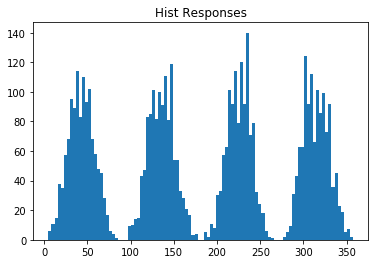

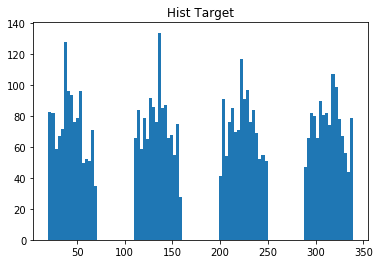

C:\Users\David\Anaconda2\envs\python3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\David\Anaconda2\envs\python3\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


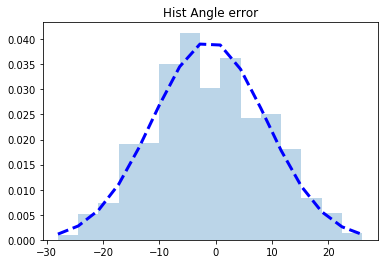

Mean      Sigma
-1.133641  10.079291


In [3]:
#Plot data

n_trials=len(df)
print('number of trials = ', n_trials)
N=len(unique(df.subject))
print('N = ', N)

#Security controls
plt.title('Hist Responses')
plt.hist(df['A_res'], bins=100)
plt.show()

plt.title('Hist Target')
plt.hist(df['A_T'], bins=100)
plt.show()


plt.title('Hist Angle error')
n_bins=15
HIST=plt.hist(df['A_err'], bins=n_bins, alpha=0.3, normed=1)[1]
mu, sigma=norm.fit(df['A_err'])
y_err = plt.mlab.normpdf(HIST, mu, sigma)
plt.plot( HIST, y_err, 'b--', linewidth=3)
plt.show()
dn = pd.DataFrame({"Mean": [mu], "Sigma":[sigma]})
print(dn.to_string(index=False))




In [4]:
## Correct the distractor (real and theoretical) (real is the closest)
real_dist = give_closer_dist_angle(list(df.A_T), list(df.A_dist), list(df.A_NT1_dist), list(df.A_NT2_dist))
df['theoretical_dist']=df['A_dist'].copy()
df['A_dist'] = real_dist

In [5]:
#Correct the bias of the quadrants (Joao & Heike)

#Functions
def circdist(array1,array2):
    from numpy import array
    res=[]
    ## Returns the minimal distance in angles between to arrays of angles
    for i in range(0, len(array1)):
        op1=abs(array2[i]-array1[i])
        angs=[array1[i],array2[i]]
        op2=min(angs)+(360-max(angs))
        options=[op1,op2]
        res.append( min(options) )
    
    return array(res)


def rem_sys_err2(report,target,frac=0.25): #frac=.25 (0.1 overfit --> bigger value you increase the window)
   #''' Removes from the response the systematic error of the subject.'''
   fit_resp = loess.lowess(report, target, frac = frac, return_sorted = False)
   fit_error = circdist(fit_resp, array(target))
   clean_res = circdist(array(report), fit_error) # Clean response ?
   return clean_res,fit_error, fit_resp


#Apply function
clean_res,fit_error, fit_resp = rem_sys_err2(df.A_res, df.A_T)

df['A_R_jh']=fit_resp
df['A_err_jh']= df[['A_T', 'A_R_jh']].apply(angle_error_col, axis=1) #df['A_T'] - df['A_R_jh']


#Step3 :Mean center by quadrant
Mean_error_jh={}

for Subject in list_subjects:
    for q, quadrant in enumerate([1,2,3,4]):        
        data_quadrant = df.loc[(df['subject']==Subject) & (df['type']==3) & (df['cue_resp']==quadrant) ]
        Mean_error_jh[str(Subject) + '_' +str(quadrant)] = data_quadrant.A_err_jh.mean()


response_corr=[]
for i in range(0, len(df) ):
    coef_use = str(int(df['subject'].iloc[i])) + '_' +str(int(df['cue_resp'].iloc[i]))
    mean_centered = df['A_R_jh'].iloc[i] + Mean_error_jh[coef_use]
    response_corr.append(mean_centered)


#Set the new error after mean centering
df['A_R_jh']=  response_corr
df['A_err_jh'] = df[['A_T', 'A_R_jh']].apply(angle_error_col, axis=1)   #df['A_T'] - df['A_R_jh']

C:\Users\David\Anaconda2\envs\python3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.085
Method:                 Least Squares   F-statistic:                    0.2914
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.604
Time:                        12:20:09   Log-Likelihood:                -34.746
No. Observations:                  10   AIC:                             73.49
Df Residuals:                       8   BIC:                             74.10
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4374      4.528      1.642      0.1

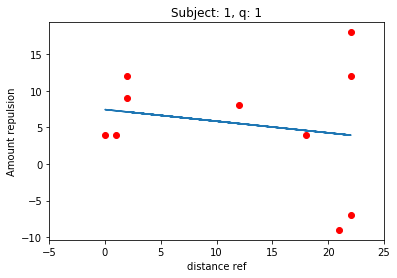

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     2.650
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.126
Time:                        12:20:09   Log-Likelihood:                -57.565
No. Observations:                  16   AIC:                             119.1
Df Residuals:                      14   BIC:                             120.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0547      4.734      1.490      0.1

C:\Users\David\Anaconda2\envs\python3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


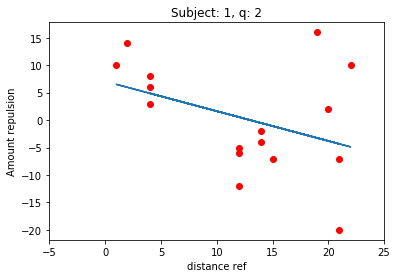

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     3.327
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0981
Time:                        12:20:10   Log-Likelihood:                -39.577
No. Observations:                  12   AIC:                             83.15
Df Residuals:                      10   BIC:                             84.12
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.9305      3.333      2.680      0.0

C:\Users\David\Anaconda2\envs\python3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


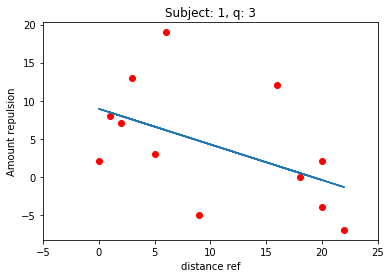

C:\Users\David\Anaconda2\envs\python3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.083
Method:                 Least Squares   F-statistic:                   0.08044
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.782
Time:                        12:20:10   Log-Likelihood:                -42.525
No. Observations:                  13   AIC:                             89.05
Df Residuals:                      11   BIC:                             90.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.1671      4.542      1.578      0.1

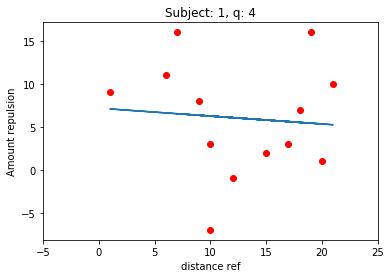

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.083
Method:                 Least Squares   F-statistic:                  0.004015
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.951
Time:                        12:20:10   Log-Likelihood:                -43.346
No. Observations:                  14   AIC:                             90.69
Df Residuals:                      12   BIC:                             91.97
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2182      2.784      1.515      0.1

C:\Users\David\Anaconda2\envs\python3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


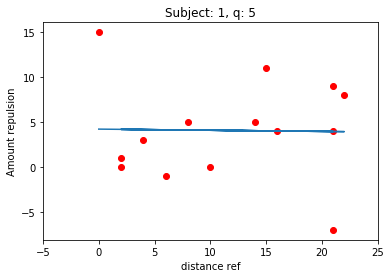

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     4.649
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0565
Time:                        12:20:10   Log-Likelihood:                -39.311
No. Observations:                  12   AIC:                             82.62
Df Residuals:                      10   BIC:                             83.59
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.1899      3.327      2.462      0.0

C:\Users\David\Anaconda2\envs\python3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


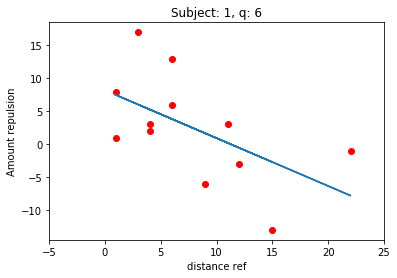

C:\Users\David\Anaconda2\envs\python3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     5.963
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0285
Time:                        12:20:10   Log-Likelihood:                -51.850
No. Observations:                  16   AIC:                             107.7
Df Residuals:                      14   BIC:                             109.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.9950      2.792      3.580      0.0

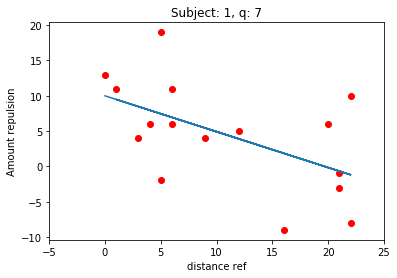

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.064
Method:                 Least Squares   F-statistic:                    0.2214
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.646
Time:                        12:20:10   Log-Likelihood:                -46.195
No. Observations:                  14   AIC:                             96.39
Df Residuals:                      12   BIC:                             97.67
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3053      4.008      0.575      0.5

C:\Users\David\Anaconda2\envs\python3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


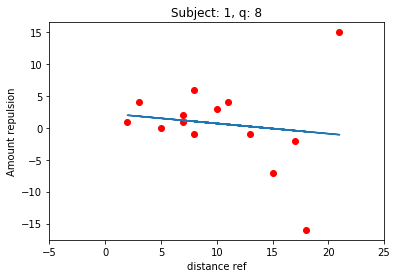

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     2.544
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.124
Time:                        12:20:11   Log-Likelihood:                -86.518
No. Observations:                  25   AIC:                             177.0
Df Residuals:                      23   BIC:                             179.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6996      2.926      1.606      0.1

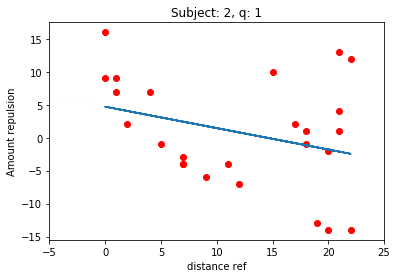

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     2.069
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.165
Time:                        12:20:11   Log-Likelihood:                -74.910
No. Observations:                  23   AIC:                             153.8
Df Residuals:                      21   BIC:                             156.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.4461      3.688      3.104      0.0

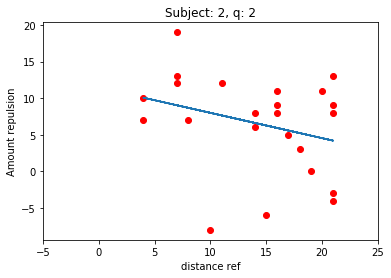

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.035
Method:                 Least Squares   F-statistic:                    0.2914
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.595
Time:                        12:20:11   Log-Likelihood:                -72.062
No. Observations:                  22   AIC:                             148.1
Df Residuals:                      20   BIC:                             150.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8761      2.635      1.850      0.0

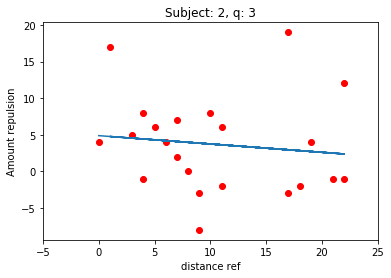

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     5.315
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0297
Time:                        12:20:11   Log-Likelihood:                -85.032
No. Observations:                  27   AIC:                             174.1
Df Residuals:                      25   BIC:                             176.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.5722      2.437      2.286      0.0

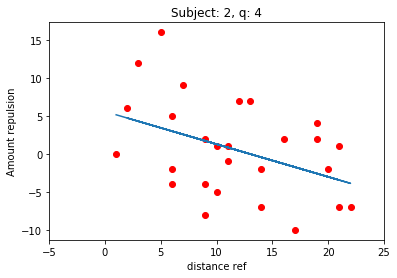

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     2.869
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0997
Time:                        12:20:11   Log-Likelihood:                -118.18
No. Observations:                  35   AIC:                             240.4
Df Residuals:                      33   BIC:                             243.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.4454      2.111      3.053      0.0

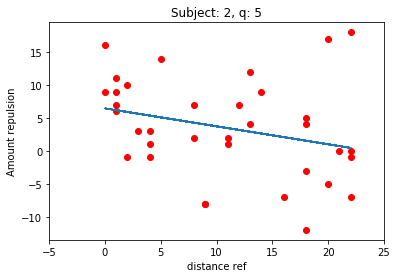

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.040
Method:                 Least Squares   F-statistic:                   0.02896
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.866
Time:                        12:20:11   Log-Likelihood:                -81.878
No. Observations:                  26   AIC:                             167.8
Df Residuals:                      24   BIC:                             170.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1011      2.265      2.253      0.0

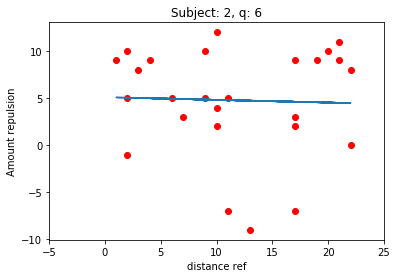

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     6.037
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0198
Time:                        12:20:12   Log-Likelihood:                -108.57
No. Observations:                  33   AIC:                             221.1
Df Residuals:                      31   BIC:                             224.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.2819      2.222      4.178      0.0

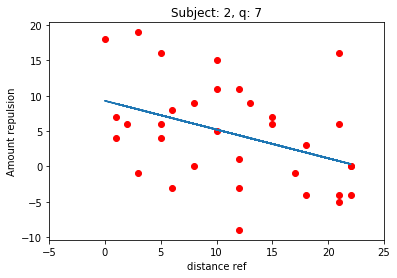

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     4.744
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0390
Time:                        12:20:12   Log-Likelihood:                -87.014
No. Observations:                  27   AIC:                             178.0
Df Residuals:                      25   BIC:                             180.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0816      2.065      2.945      0.0

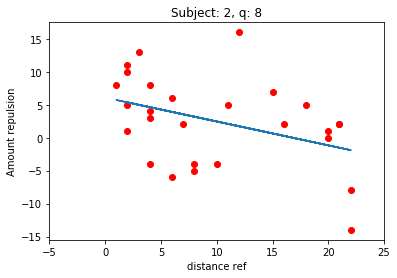

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.198
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.287
Time:                        12:20:12   Log-Likelihood:                -72.686
No. Observations:                  22   AIC:                             149.4
Df Residuals:                      20   BIC:                             151.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3733      3.177     -0.117      0.9

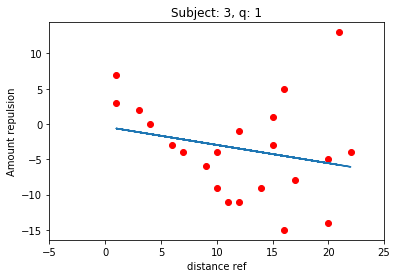

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.107
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.301
Time:                        12:20:12   Log-Likelihood:                -114.00
No. Observations:                  33   AIC:                             232.0
Df Residuals:                      31   BIC:                             235.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7176      2.927      0.587      0.5

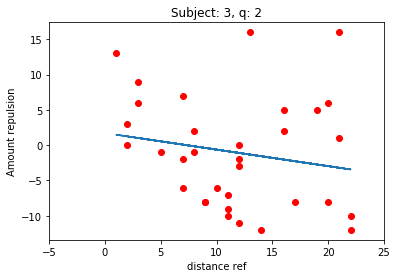

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     1.871
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.185
Time:                        12:20:12   Log-Likelihood:                -85.640
No. Observations:                  25   AIC:                             175.3
Df Residuals:                      23   BIC:                             177.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6180      3.016      0.868      0.3

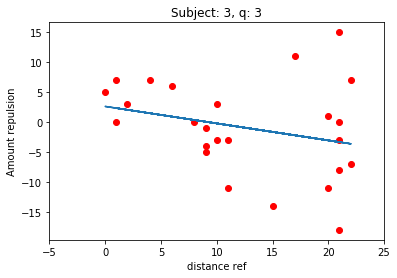

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     22.73
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           6.80e-05
Time:                        12:20:12   Log-Likelihood:                -86.510
No. Observations:                  27   AIC:                             177.0
Df Residuals:                      25   BIC:                             179.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0724      2.219      3.638      0.0

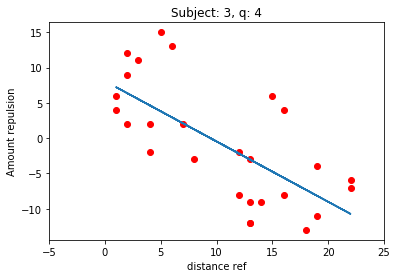

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.250
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.276
Time:                        12:20:13   Log-Likelihood:                -85.342
No. Observations:                  24   AIC:                             174.7
Df Residuals:                      22   BIC:                             177.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2000      3.259      0.982      0.3

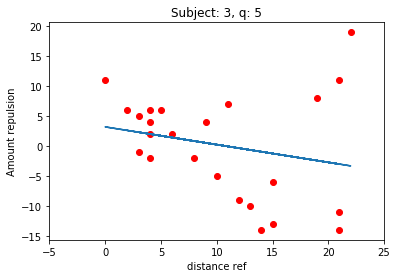

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     5.146
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0309
Time:                        12:20:13   Log-Likelihood:                -107.43
No. Observations:                  31   AIC:                             218.9
Df Residuals:                      29   BIC:                             221.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4324      3.040      1.458      0.1

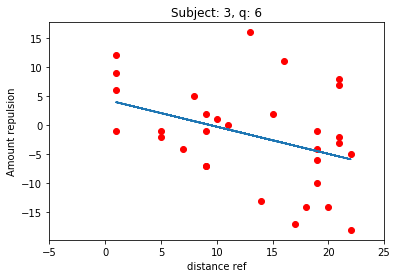

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     1.993
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.168
Time:                        12:20:13   Log-Likelihood:                -110.17
No. Observations:                  33   AIC:                             224.3
Df Residuals:                      31   BIC:                             227.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1221      2.472      1.263      0.2

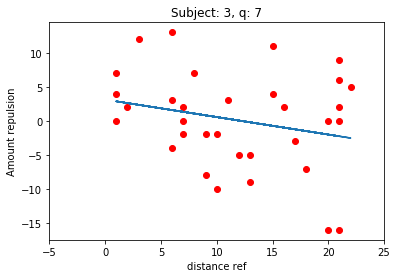

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     5.243
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0330
Time:                        12:20:13   Log-Likelihood:                -76.270
No. Observations:                  22   AIC:                             156.5
Df Residuals:                      20   BIC:                             158.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0309      3.423      1.178      0.2

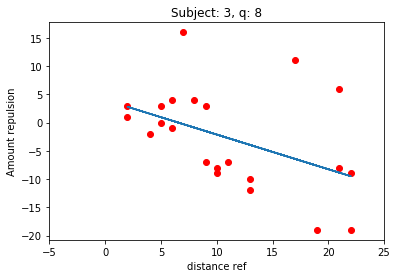

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     4.432
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0435
Time:                        12:20:13   Log-Likelihood:                -120.12
No. Observations:                  33   AIC:                             244.2
Df Residuals:                      31   BIC:                             247.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8266      2.934      1.986      0.0

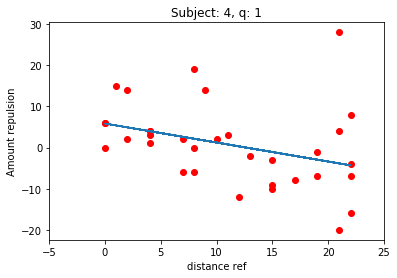

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     6.080
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0239
Time:                        12:20:13   Log-Likelihood:                -70.406
No. Observations:                  20   AIC:                             144.8
Df Residuals:                      18   BIC:                             146.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.7037      3.740      2.327      0.0

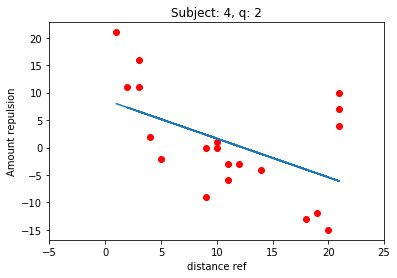

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     62.72
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           7.72e-09
Time:                        12:20:13   Log-Likelihood:                -91.703
No. Observations:                  32   AIC:                             187.4
Df Residuals:                      30   BIC:                             190.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.1974      1.554      5.274      0.0

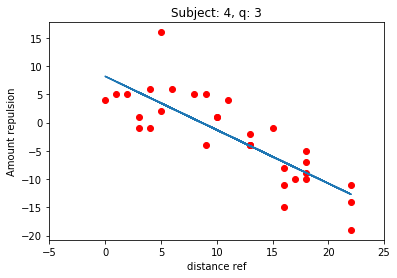

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     7.039
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0134
Time:                        12:20:14   Log-Likelihood:                -95.391
No. Observations:                  28   AIC:                             194.8
Df Residuals:                      26   BIC:                             197.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.9569      2.720      2.926      0.0

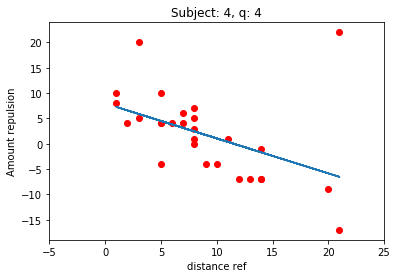

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     18.86
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           0.000177
Time:                        12:20:14   Log-Likelihood:                -93.843
No. Observations:                  29   AIC:                             191.7
Df Residuals:                      27   BIC:                             194.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.4430      1.942      4.348      0.0

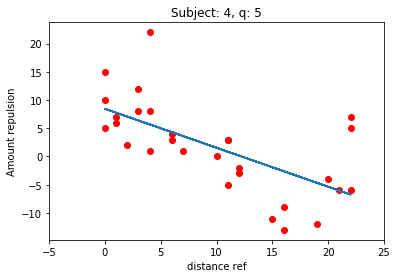

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     20.09
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           0.000186
Time:                        12:20:14   Log-Likelihood:                -78.491
No. Observations:                  24   AIC:                             161.0
Df Residuals:                      22   BIC:                             163.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.8107      2.568      3.431      0.0

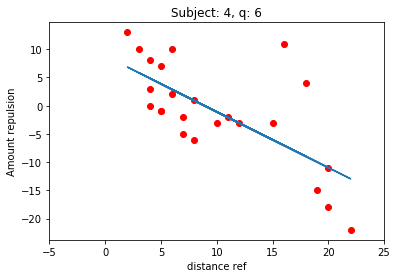

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     37.84
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           1.97e-06
Time:                        12:20:14   Log-Likelihood:                -84.391
No. Observations:                  27   AIC:                             172.8
Df Residuals:                      25   BIC:                             175.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.5583      2.025      4.227      0.0

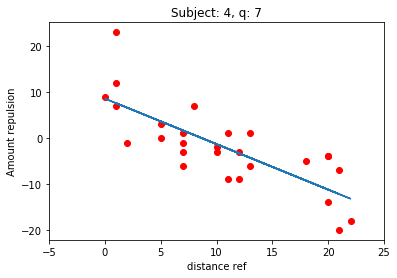

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     40.27
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           2.19e-06
Time:                        12:20:14   Log-Likelihood:                -74.515
No. Observations:                  24   AIC:                             153.0
Df Residuals:                      22   BIC:                             155.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.8319      2.909      4.754      0.0

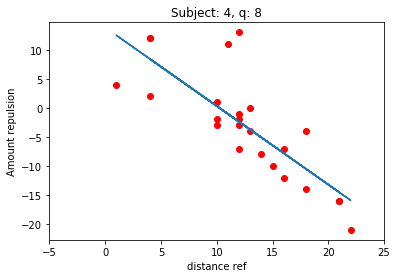

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     4.732
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0361
Time:                        12:20:14   Log-Likelihood:                -134.86
No. Observations:                  39   AIC:                             273.7
Df Residuals:                      37   BIC:                             277.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7769      2.626      1.438      0.1

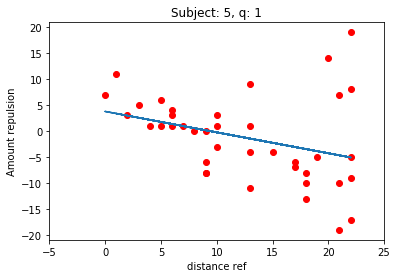

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     5.992
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0263
Time:                        12:20:15   Log-Likelihood:                -54.971
No. Observations:                  18   AIC:                             113.9
Df Residuals:                      16   BIC:                             115.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2869      2.492      1.319      0.2

C:\Users\David\Anaconda2\envs\python3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


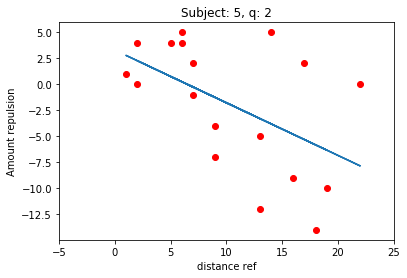

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     4.747
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0373
Time:                        12:20:15   Log-Likelihood:                -110.52
No. Observations:                  32   AIC:                             225.0
Df Residuals:                      30   BIC:                             228.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.5682      2.390      1.912      0.0

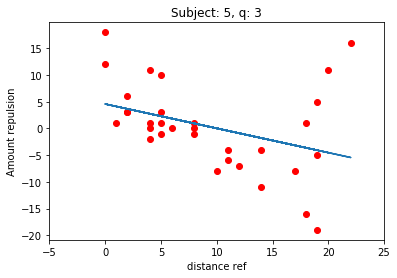

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     2.099
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.160
Time:                        12:20:15   Log-Likelihood:                -93.073
No. Observations:                  27   AIC:                             190.1
Df Residuals:                      25   BIC:                             192.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8121      3.793      1.532      0.1

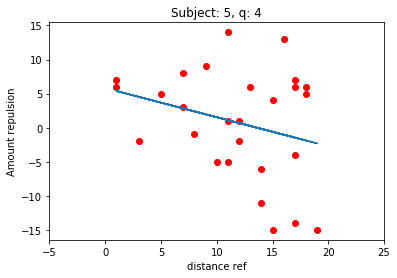

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.142
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.296
Time:                        12:20:15   Log-Likelihood:                -95.822
No. Observations:                  26   AIC:                             195.6
Df Residuals:                      24   BIC:                             198.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1561      4.041      1.028      0.3

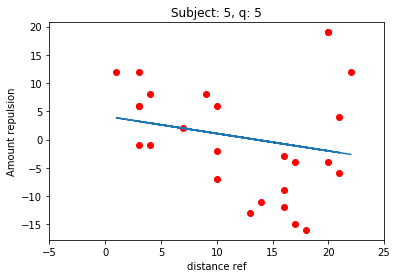

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     2.840
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.105
Time:                        12:20:15   Log-Likelihood:                -86.743
No. Observations:                  25   AIC:                             177.5
Df Residuals:                      23   BIC:                             179.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.1960      3.317      1.868      0.0

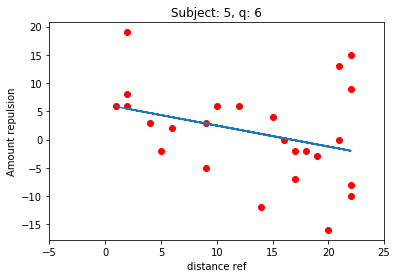

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     3.774
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0630
Time:                        12:20:15   Log-Likelihood:                -100.09
No. Observations:                  28   AIC:                             204.2
Df Residuals:                      26   BIC:                             206.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8494      3.001      1.283      0.2

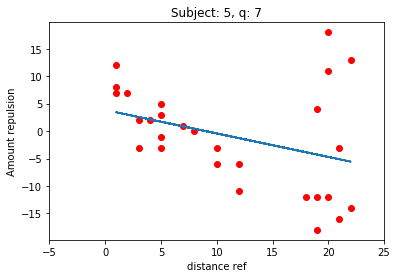

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     4.822
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0384
Time:                        12:20:16   Log-Likelihood:                -87.553
No. Observations:                  25   AIC:                             179.1
Df Residuals:                      23   BIC:                             181.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.5816      3.275      2.315      0.0

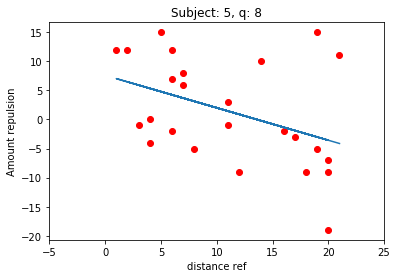

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.028
Method:                 Least Squares   F-statistic:                    0.3106
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.582
Time:                        12:20:16   Log-Likelihood:                -89.010
No. Observations:                  26   AIC:                             182.0
Df Residuals:                      24   BIC:                             184.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1836      2.665      1.194      0.2

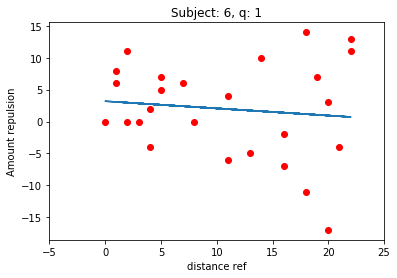

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     10.45
Date:                Tue, 23 Oct 2018   Prob (F-statistic):            0.00297
Time:                        12:20:16   Log-Likelihood:                -110.91
No. Observations:                  32   AIC:                             225.8
Df Residuals:                      30   BIC:                             228.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.9131      3.394      2.331      0.0

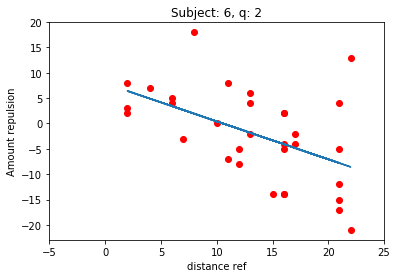

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     3.656
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0669
Time:                        12:20:16   Log-Likelihood:                -98.585
No. Observations:                  28   AIC:                             201.2
Df Residuals:                      26   BIC:                             203.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3920      2.941      1.153      0.2

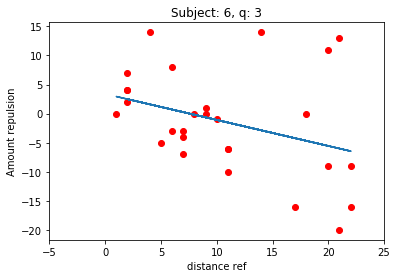

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.7996
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.380
Time:                        12:20:16   Log-Likelihood:                -91.489
No. Observations:                  27   AIC:                             187.0
Df Residuals:                      25   BIC:                             189.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8537      2.658      1.450      0.1

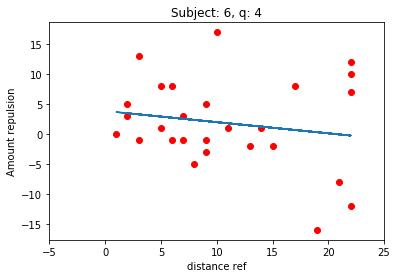

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     2.663
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.115
Time:                        12:20:17   Log-Likelihood:                -90.159
No. Observations:                  28   AIC:                             184.3
Df Residuals:                      26   BIC:                             187.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1988      2.292      2.268      0.0

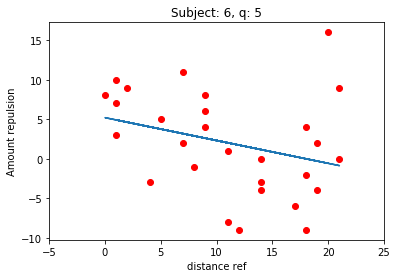

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     2.212
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.149
Time:                        12:20:17   Log-Likelihood:                -90.539
No. Observations:                  27   AIC:                             185.1
Df Residuals:                      25   BIC:                             187.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0828      2.639      1.168      0.2

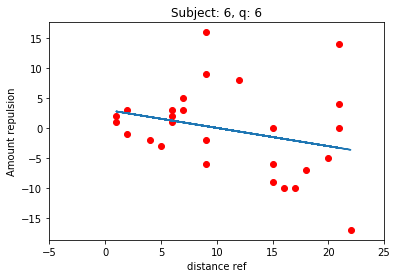

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.4251
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.521
Time:                        12:20:17   Log-Likelihood:                -91.990
No. Observations:                  26   AIC:                             188.0
Df Residuals:                      24   BIC:                             190.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6126      3.198      1.130      0.2

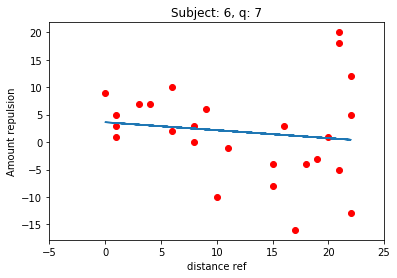

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.9073
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.350
Time:                        12:20:17   Log-Likelihood:                -99.601
No. Observations:                  28   AIC:                             203.2
Df Residuals:                      26   BIC:                             205.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3782      3.000      1.792      0.0

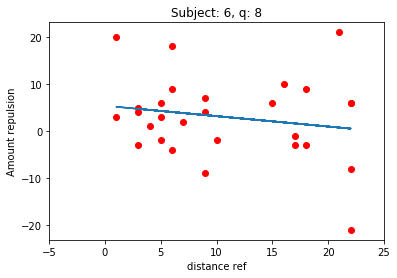

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     11.85
Date:                Tue, 23 Oct 2018   Prob (F-statistic):            0.00167
Time:                        12:20:17   Log-Likelihood:                -105.71
No. Observations:                  33   AIC:                             215.4
Df Residuals:                      31   BIC:                             218.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0237      1.991      2.021      0.0

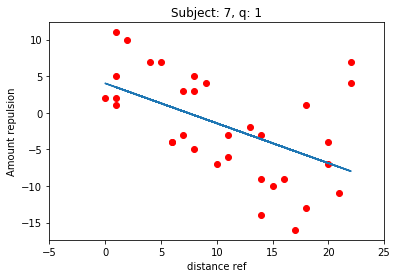

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                    0.3326
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.570
Time:                        12:20:18   Log-Likelihood:                -82.388
No. Observations:                  23   AIC:                             168.8
Df Residuals:                      21   BIC:                             171.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9828      3.796      0.522      0.6

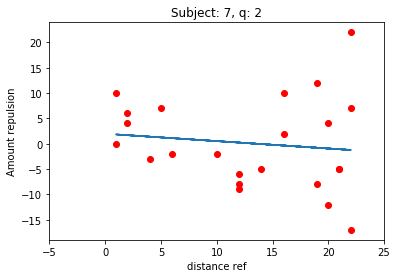

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     27.05
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           1.21e-05
Time:                        12:20:18   Log-Likelihood:                -110.18
No. Observations:                  33   AIC:                             224.4
Df Residuals:                      31   BIC:                             227.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.9062      2.515      4.337      0.0

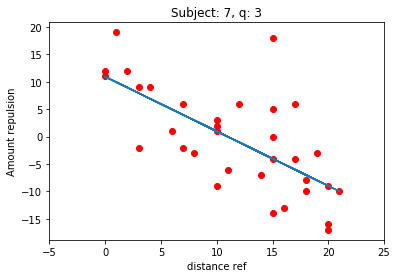

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     20.41
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           0.000210
Time:                        12:20:18   Log-Likelihood:                -70.753
No. Observations:                  22   AIC:                             145.5
Df Residuals:                      20   BIC:                             147.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.0206      2.691      3.724      0.0

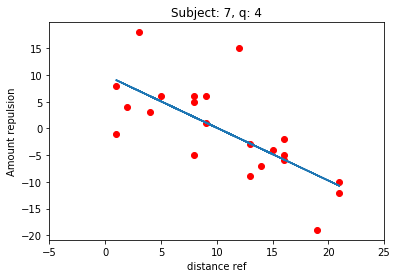

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.268
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.273
Time:                        12:20:19   Log-Likelihood:                -76.250
No. Observations:                  22   AIC:                             156.5
Df Residuals:                      20   BIC:                             158.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7702      3.277      0.540      0.5

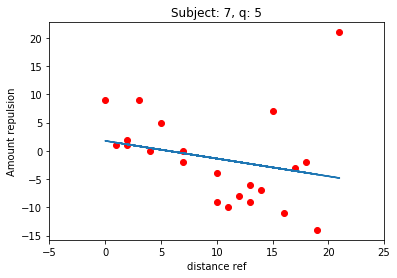

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     48.68
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           4.13e-07
Time:                        12:20:19   Log-Likelihood:                -70.886
No. Observations:                  25   AIC:                             145.8
Df Residuals:                      23   BIC:                             148.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4557      1.659      2.687      0.0

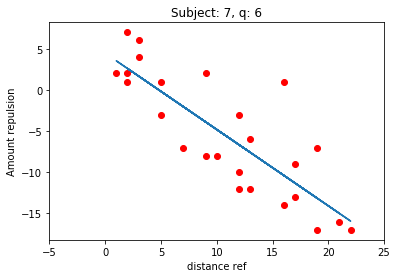

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     3.152
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0891
Time:                        12:20:19   Log-Likelihood:                -91.700
No. Observations:                  25   AIC:                             187.4
Df Residuals:                      23   BIC:                             189.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3063      4.065      1.305      0.2

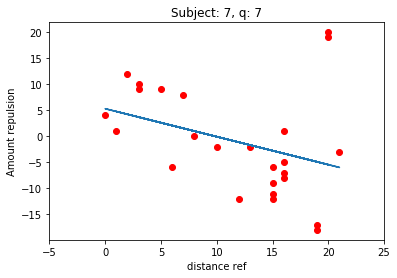

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                    0.1111
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.741
Time:                        12:20:19   Log-Likelihood:                -104.78
No. Observations:                  31   AIC:                             213.6
Df Residuals:                      29   BIC:                             216.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3669      2.619      0.904      0.3

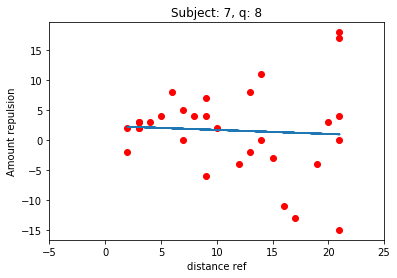

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     10.60
Date:                Tue, 23 Oct 2018   Prob (F-statistic):            0.00336
Time:                        12:20:19   Log-Likelihood:                -90.691
No. Observations:                  26   AIC:                             185.4
Df Residuals:                      24   BIC:                             187.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.6209      4.200      3.957      0.0

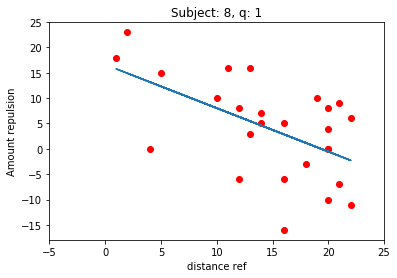

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.236
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.276
Time:                        12:20:20   Log-Likelihood:                -103.32
No. Observations:                  30   AIC:                             210.6
Df Residuals:                      28   BIC:                             213.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8039      2.952      1.288      0.2

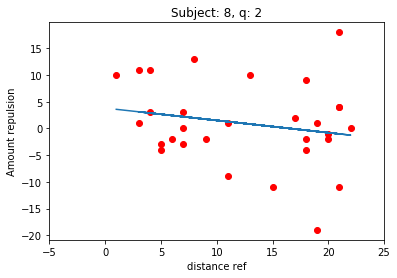

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     10.89
Date:                Tue, 23 Oct 2018   Prob (F-statistic):            0.00341
Time:                        12:20:20   Log-Likelihood:                -77.982
No. Observations:                  23   AIC:                             160.0
Df Residuals:                      21   BIC:                             162.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.4045      3.013      3.454      0.0

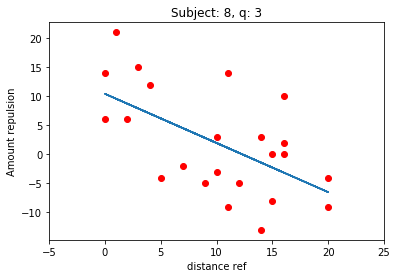

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     3.363
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0781
Time:                        12:20:20   Log-Likelihood:                -103.54
No. Observations:                  28   AIC:                             211.1
Df Residuals:                      26   BIC:                             213.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.2642      3.227      4.110      0.0

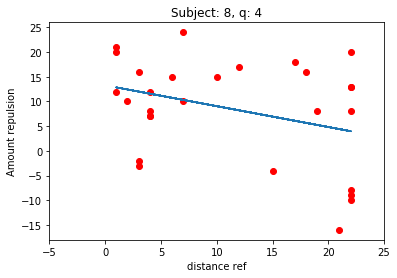

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     15.56
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           0.000487
Time:                        12:20:20   Log-Likelihood:                -94.226
No. Observations:                  30   AIC:                             192.5
Df Residuals:                      28   BIC:                             195.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4694      2.037      3.666      0.0

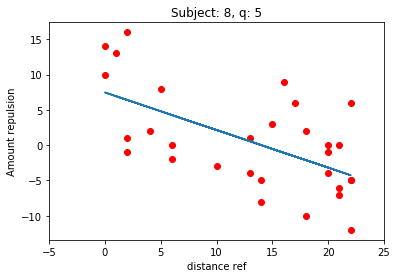

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     2.606
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.120
Time:                        12:20:20   Log-Likelihood:                -82.620
No. Observations:                  25   AIC:                             169.2
Df Residuals:                      23   BIC:                             171.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4596      2.203      3.386      0.0

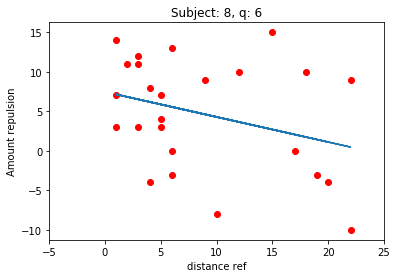

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.382
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.250
Time:                        12:20:21   Log-Likelihood:                -107.13
No. Observations:                  30   AIC:                             218.3
Df Residuals:                      28   BIC:                             221.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0157      2.990      1.009      0.3

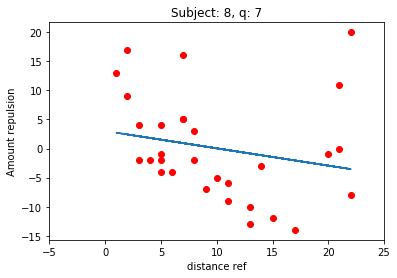

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     16.91
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           0.000426
Time:                        12:20:21   Log-Likelihood:                -81.868
No. Observations:                  25   AIC:                             167.7
Df Residuals:                      23   BIC:                             170.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.7889      2.952      5.010      0.0

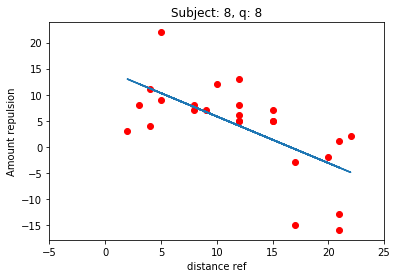

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     3.451
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0724
Time:                        12:20:21   Log-Likelihood:                -111.59
No. Observations:                  34   AIC:                             227.2
Df Residuals:                      32   BIC:                             230.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.4917      2.418      2.685      0.0

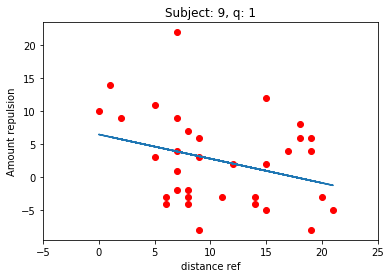

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     3.233
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0890
Time:                        12:20:21   Log-Likelihood:                -65.756
No. Observations:                  20   AIC:                             135.5
Df Residuals:                      18   BIC:                             137.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.6242      2.967      3.580      0.0

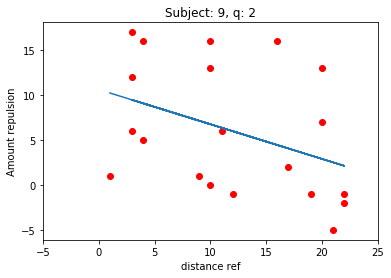

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     2.518
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.122
Time:                        12:20:21   Log-Likelihood:                -122.35
No. Observations:                  36   AIC:                             248.7
Df Residuals:                      34   BIC:                             251.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.8914      1.899      4.155      0.0

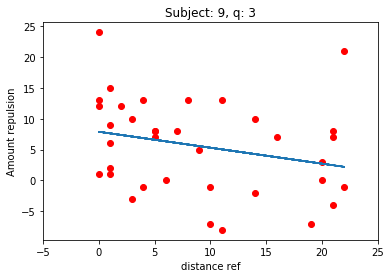

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.043
Method:                 Least Squares   F-statistic:                   0.08595
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.772
Time:                        12:20:21   Log-Likelihood:                -76.231
No. Observations:                  23   AIC:                             156.5
Df Residuals:                      21   BIC:                             158.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.2244      3.149      1.977      0.0

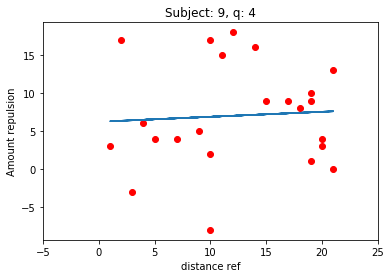

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.028
Method:                 Least Squares   F-statistic:                    0.1519
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.699
Time:                        12:20:22   Log-Likelihood:                -110.57
No. Observations:                  32   AIC:                             225.1
Df Residuals:                      30   BIC:                             228.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9176      3.162      0.923      0.3

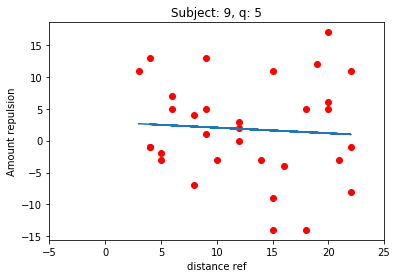

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     9.786
Date:                Tue, 23 Oct 2018   Prob (F-statistic):            0.00508
Time:                        12:20:22   Log-Likelihood:                -70.788
No. Observations:                  23   AIC:                             145.6
Df Residuals:                      21   BIC:                             147.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.7609      2.373      4.956      0.0

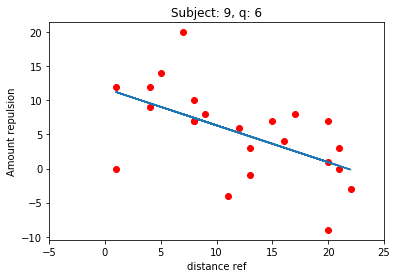

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     8.436
Date:                Tue, 23 Oct 2018   Prob (F-statistic):            0.00673
Time:                        12:20:22   Log-Likelihood:                -110.20
No. Observations:                  33   AIC:                             224.4
Df Residuals:                      31   BIC:                             227.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.9588      2.453      5.283      0.0

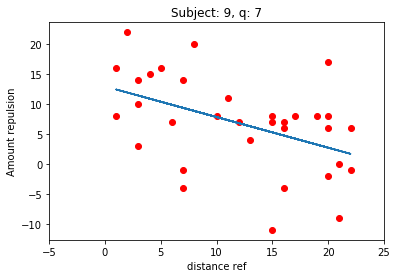

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1.557
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.227
Time:                        12:20:22   Log-Likelihood:                -74.045
No. Observations:                  22   AIC:                             152.1
Df Residuals:                      20   BIC:                             154.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.2085      2.949      4.140      0.0

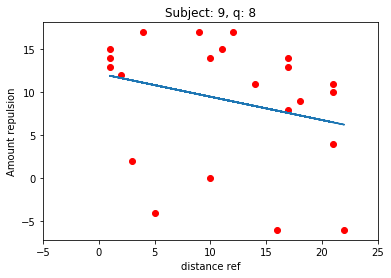

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     22.34
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           5.42e-05
Time:                        12:20:22   Log-Likelihood:                -106.52
No. Observations:                  31   AIC:                             217.0
Df Residuals:                      29   BIC:                             219.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.2002      2.780      4.389      0.0

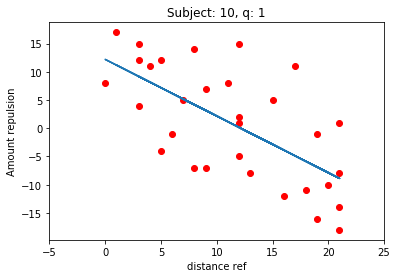

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     3.426
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0765
Time:                        12:20:22   Log-Likelihood:                -90.876
No. Observations:                  26   AIC:                             185.8
Df Residuals:                      24   BIC:                             188.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4079      3.023      1.458      0.1

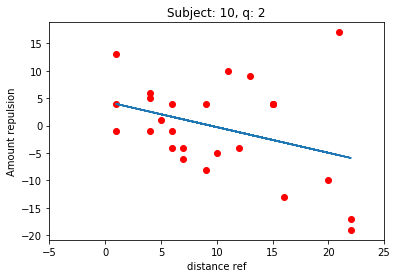

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     1.854
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.184
Time:                        12:20:23   Log-Likelihood:                -111.74
No. Observations:                  31   AIC:                             227.5
Df Residuals:                      29   BIC:                             230.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0686      3.048      1.007      0.3

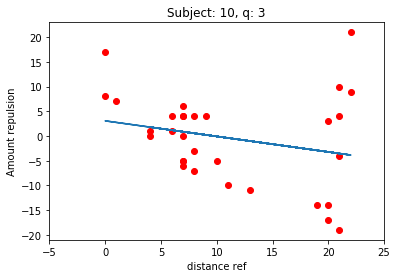

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.304
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.264
Time:                        12:20:23   Log-Likelihood:                -91.793
No. Observations:                  27   AIC:                             187.6
Df Residuals:                      25   BIC:                             190.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1377      2.936      1.409      0.1

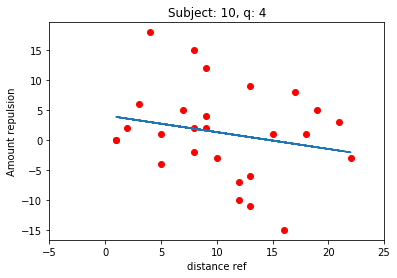

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                    0.5069
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.485
Time:                        12:20:23   Log-Likelihood:                -72.257
No. Observations:                  21   AIC:                             148.5
Df Residuals:                      19   BIC:                             150.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4551      3.740      0.656      0.5

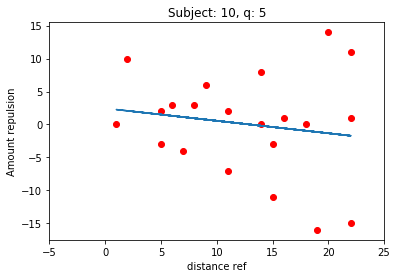

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     10.72
Date:                Tue, 23 Oct 2018   Prob (F-statistic):            0.00249
Time:                        12:20:23   Log-Likelihood:                -117.61
No. Observations:                  35   AIC:                             239.2
Df Residuals:                      33   BIC:                             242.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.0948      2.408      5.024      0.0

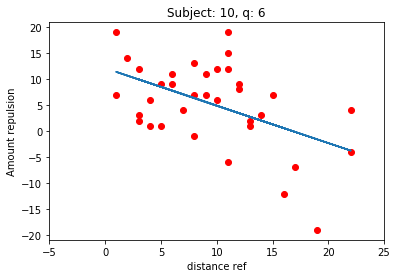

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     11.00
Date:                Tue, 23 Oct 2018   Prob (F-statistic):            0.00261
Time:                        12:20:23   Log-Likelihood:                -99.951
No. Observations:                  29   AIC:                             203.9
Df Residuals:                      27   BIC:                             206.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.6543      2.474      5.114      0.0

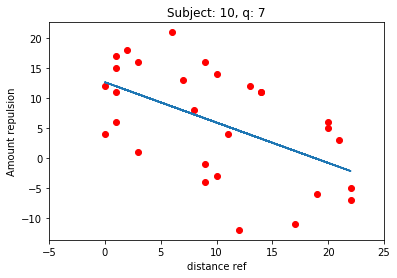

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.5242
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.478
Time:                        12:20:23   Log-Likelihood:                -68.850
No. Observations:                  21   AIC:                             141.7
Df Residuals:                      19   BIC:                             143.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1379      2.684      0.797      0.4

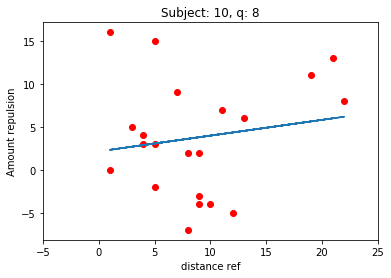

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1.806
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.189
Time:                        12:20:24   Log-Likelihood:                -105.74
No. Observations:                  31   AIC:                             215.5
Df Residuals:                      29   BIC:                             218.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.9192      2.403      3.296      0.0

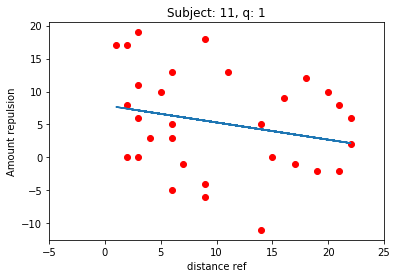

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     12.09
Date:                Tue, 23 Oct 2018   Prob (F-statistic):            0.00238
Time:                        12:20:24   Log-Likelihood:                -69.837
No. Observations:                  22   AIC:                             143.7
Df Residuals:                      20   BIC:                             145.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.5255      2.070      4.120      0.0

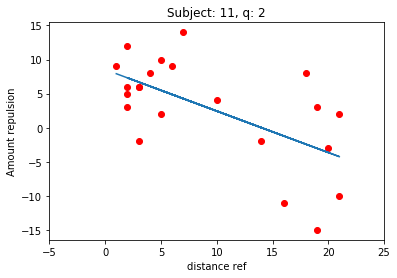

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.5592
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.461
Time:                        12:20:24   Log-Likelihood:                -98.891
No. Observations:                  31   AIC:                             201.8
Df Residuals:                      29   BIC:                             204.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6434      2.301      2.018      0.0

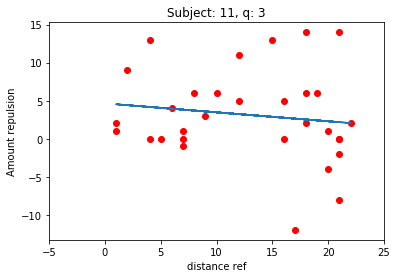

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                    0.3101
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.582
Time:                        12:20:24   Log-Likelihood:                -98.782
No. Observations:                  28   AIC:                             201.6
Df Residuals:                      26   BIC:                             204.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5147      3.615      0.972      0.3

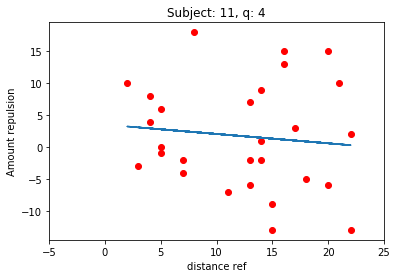

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     1.930
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.179
Time:                        12:20:24   Log-Likelihood:                -77.959
No. Observations:                  23   AIC:                             159.9
Df Residuals:                      21   BIC:                             162.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6952      2.900      1.274      0.2

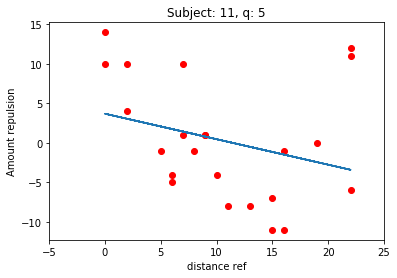

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     7.732
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0106
Time:                        12:20:24   Log-Likelihood:                -79.041
No. Observations:                  25   AIC:                             162.1
Df Residuals:                      23   BIC:                             164.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.8853      2.292      3.004      0.0

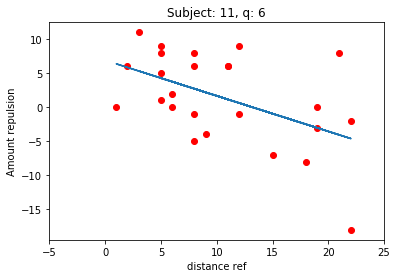

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.038
Method:                 Least Squares   F-statistic:                   0.07344
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.789
Time:                        12:20:24   Log-Likelihood:                -86.302
No. Observations:                  26   AIC:                             176.6
Df Residuals:                      24   BIC:                             179.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2517      2.348      0.533      0.5

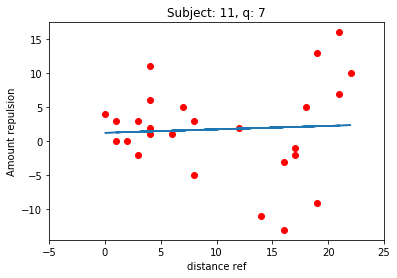

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1.952
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.173
Time:                        12:20:25   Log-Likelihood:                -100.42
No. Observations:                  31   AIC:                             204.8
Df Residuals:                      29   BIC:                             207.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8843      2.221      1.298      0.2

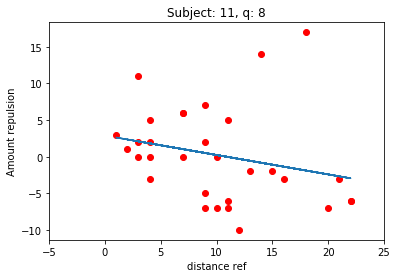

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.334
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.258
Time:                        12:20:25   Log-Likelihood:                -107.21
No. Observations:                  30   AIC:                             218.4
Df Residuals:                      28   BIC:                             221.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2312      3.516      2.341      0.0

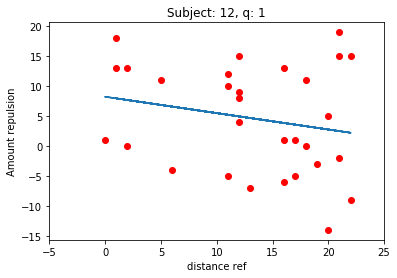

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     5.421
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0273
Time:                        12:20:25   Log-Likelihood:                -98.771
No. Observations:                  30   AIC:                             201.5
Df Residuals:                      28   BIC:                             204.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.3910      2.349      3.573      0.0

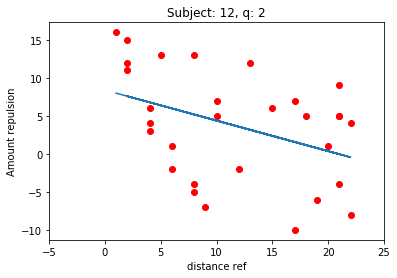

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                   0.05050
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.824
Time:                        12:20:25   Log-Likelihood:                -108.92
No. Observations:                  33   AIC:                             221.8
Df Residuals:                      31   BIC:                             224.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0548      2.436      2.896      0.0

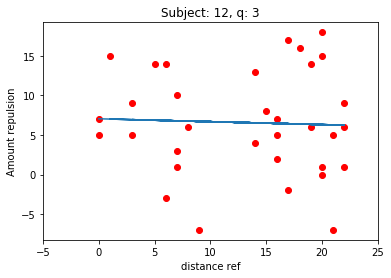

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.037
Method:                 Least Squares   F-statistic:                    0.1176
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.735
Time:                        12:20:25   Log-Likelihood:                -90.910
No. Observations:                  26   AIC:                             185.8
Df Residuals:                      24   BIC:                             188.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.6886      3.042      1.870      0.0

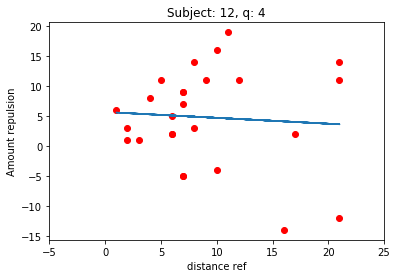

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.8139
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.377
Time:                        12:20:25   Log-Likelihood:                -81.620
No. Observations:                  24   AIC:                             167.2
Df Residuals:                      22   BIC:                             169.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.9724      2.457      2.837      0.0

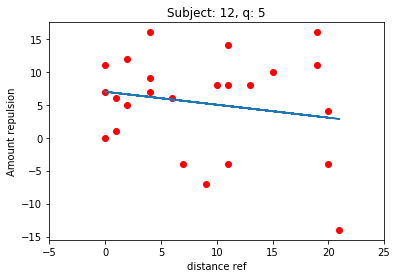

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.8036
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.379
Time:                        12:20:25   Log-Likelihood:                -81.789
No. Observations:                  25   AIC:                             167.6
Df Residuals:                      23   BIC:                             170.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0485      2.839      0.369      0.7

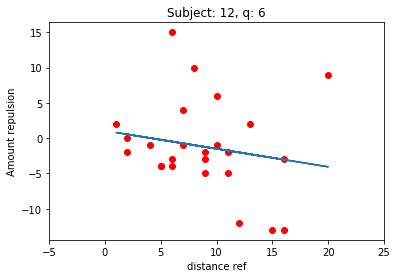

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     7.631
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0104
Time:                        12:20:26   Log-Likelihood:                -84.576
No. Observations:                  28   AIC:                             173.2
Df Residuals:                      26   BIC:                             175.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0547      2.027      1.507      0.1

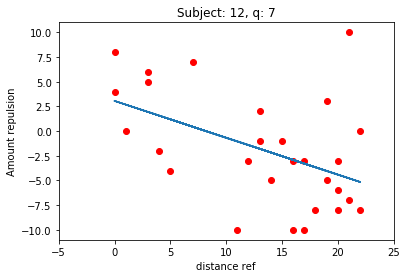

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.139
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.298
Time:                        12:20:26   Log-Likelihood:                -82.742
No. Observations:                  23   AIC:                             169.5
Df Residuals:                      21   BIC:                             171.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.1857      4.189      1.477      0.1

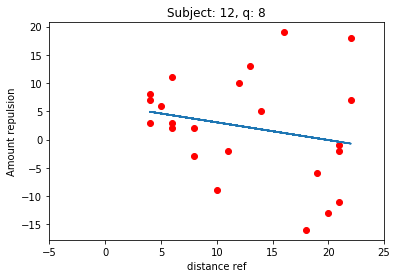

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     1.695
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.202
Time:                        12:20:26   Log-Likelihood:                -118.83
No. Observations:                  35   AIC:                             241.7
Df Residuals:                      33   BIC:                             244.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8792      2.392      2.040      0.0

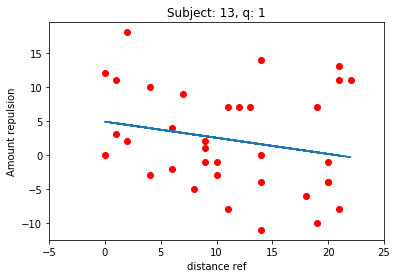

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.9233
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.348
Time:                        12:20:26   Log-Likelihood:                -83.852
No. Observations:                  23   AIC:                             171.7
Df Residuals:                      21   BIC:                             174.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2896      4.533      0.284      0.7

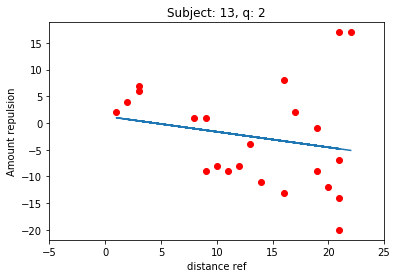

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     11.04
Date:                Tue, 23 Oct 2018   Prob (F-statistic):            0.00236
Time:                        12:20:26   Log-Likelihood:                -100.71
No. Observations:                  32   AIC:                             205.4
Df Residuals:                      30   BIC:                             208.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0827      1.827      2.234      0.0

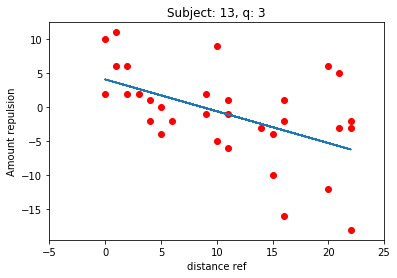

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     3.386
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0782
Time:                        12:20:26   Log-Likelihood:                -89.412
No. Observations:                  26   AIC:                             182.8
Df Residuals:                      24   BIC:                             185.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.6057      3.246      2.651      0.0

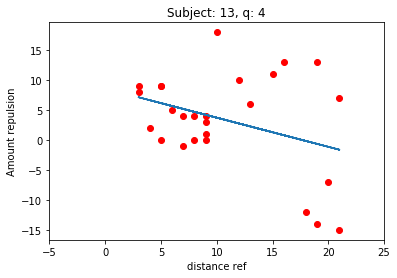

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     3.442
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0759
Time:                        12:20:27   Log-Likelihood:                -90.801
No. Observations:                  26   AIC:                             185.6
Df Residuals:                      24   BIC:                             188.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2751      3.437      1.244      0.2

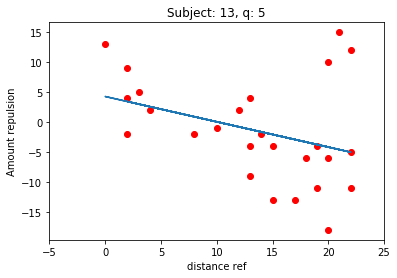

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     2.338
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.138
Time:                        12:20:27   Log-Likelihood:                -96.197
No. Observations:                  28   AIC:                             196.4
Df Residuals:                      26   BIC:                             199.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.6543      2.868      1.972      0.0

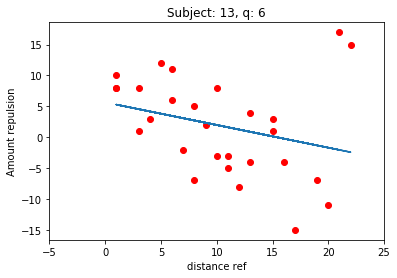

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.203
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.285
Time:                        12:20:27   Log-Likelihood:                -78.398
No. Observations:                  24   AIC:                             160.8
Df Residuals:                      22   BIC:                             163.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9270      3.863      0.758      0.4

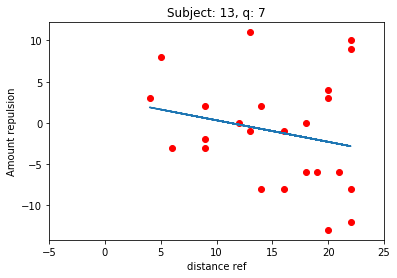

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     6.905
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0148
Time:                        12:20:27   Log-Likelihood:                -85.119
No. Observations:                  26   AIC:                             174.2
Df Residuals:                      24   BIC:                             176.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2536      2.125      2.472      0.0

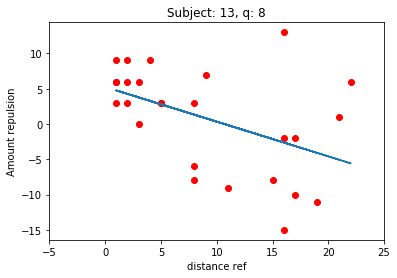

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     10.83
Date:                Tue, 23 Oct 2018   Prob (F-statistic):            0.00270
Time:                        12:20:27   Log-Likelihood:                -99.287
No. Observations:                  30   AIC:                             202.6
Df Residuals:                      28   BIC:                             205.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0179      2.117      2.843      0.0

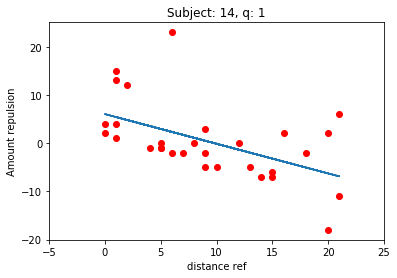

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.028
Method:                 Least Squares   F-statistic:                    0.3701
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.549
Time:                        12:20:27   Log-Likelihood:                -74.801
No. Observations:                  24   AIC:                             153.6
Df Residuals:                      22   BIC:                             156.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4796      1.987      1.751      0.0

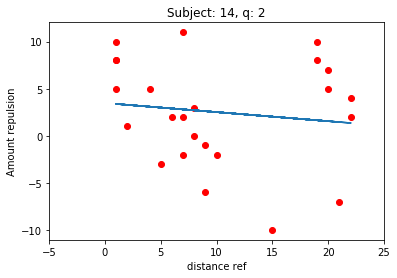

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     2.097
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.161
Time:                        12:20:28   Log-Likelihood:                -91.072
No. Observations:                  26   AIC:                             186.1
Df Residuals:                      24   BIC:                             188.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5808      4.091      0.631      0.5

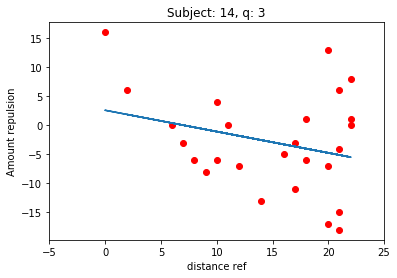

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     2.750
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.108
Time:                        12:20:28   Log-Likelihood:                -109.09
No. Observations:                  32   AIC:                             222.2
Df Residuals:                      30   BIC:                             225.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2896      2.454      0.525      0.6

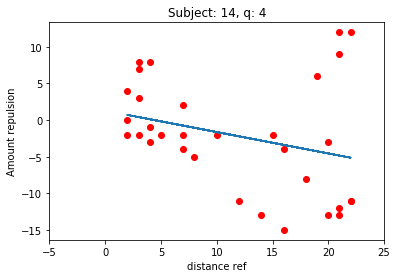

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9935
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.327
Time:                        12:20:28   Log-Likelihood:                -108.29
No. Observations:                  30   AIC:                             220.6
Df Residuals:                      28   BIC:                             223.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9912      2.668      1.121      0.2

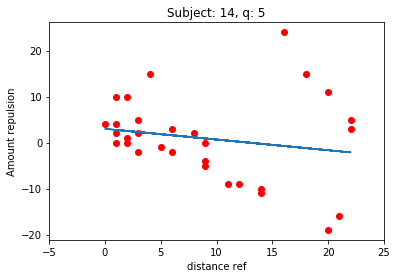

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     4.649
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0405
Time:                        12:20:28   Log-Likelihood:                -94.618
No. Observations:                  28   AIC:                             193.2
Df Residuals:                      26   BIC:                             195.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.2694      3.495      2.652      0.0

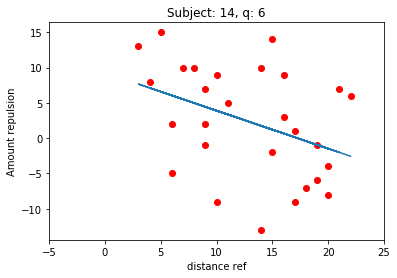

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                    0.4659
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.504
Time:                        12:20:28   Log-Likelihood:                -66.806
No. Observations:                  19   AIC:                             137.6
Df Residuals:                      17   BIC:                             139.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8021      3.743     -0.214      0.8

C:\Users\David\Anaconda2\envs\python3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


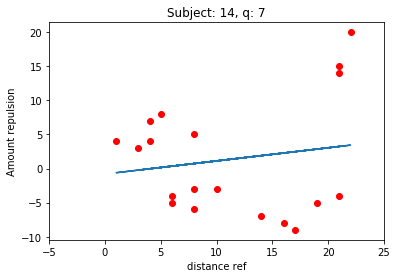

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     2.626
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.116
Time:                        12:20:28   Log-Likelihood:                -105.13
No. Observations:                  31   AIC:                             214.3
Df Residuals:                      29   BIC:                             217.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0435      2.812      2.505      0.0

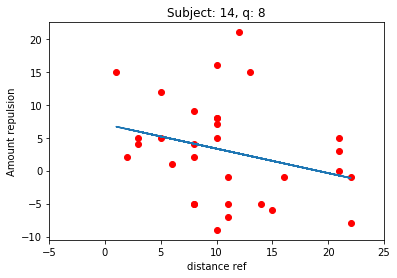

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.033
Method:                 Least Squares   F-statistic:                   0.03483
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.853
Time:                        12:20:29   Log-Likelihood:                -115.19
No. Observations:                  31   AIC:                             234.4
Df Residuals:                      29   BIC:                             237.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8205      3.702     -0.492      0.6

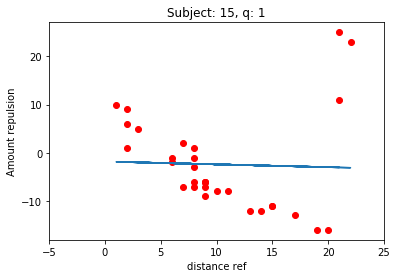

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     36.99
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           2.35e-06
Time:                        12:20:29   Log-Likelihood:                -76.458
No. Observations:                  27   AIC:                             156.9
Df Residuals:                      25   BIC:                             159.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3213      1.498      2.885      0.0

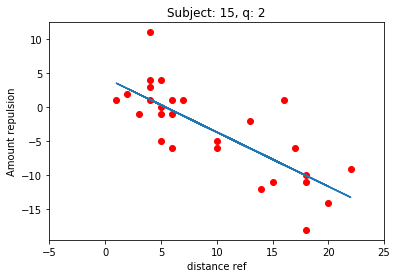

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     4.544
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0439
Time:                        12:20:29   Log-Likelihood:                -85.661
No. Observations:                  25   AIC:                             175.3
Df Residuals:                      23   BIC:                             177.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3437      3.013      1.442      0.1

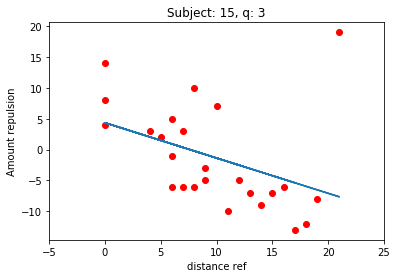

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.045
Method:                 Least Squares   F-statistic:                  0.001708
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.967
Time:                        12:20:29   Log-Likelihood:                -88.017
No. Observations:                  24   AIC:                             180.0
Df Residuals:                      22   BIC:                             182.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7929      3.611     -0.220      0.8

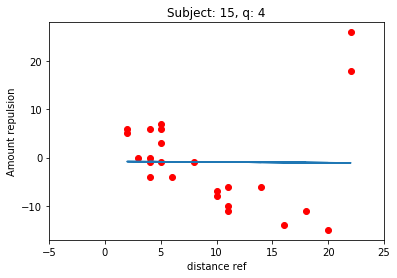

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     2.826
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.103
Time:                        12:20:29   Log-Likelihood:                -123.10
No. Observations:                  33   AIC:                             250.2
Df Residuals:                      31   BIC:                             253.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0905      3.575      0.585      0.5

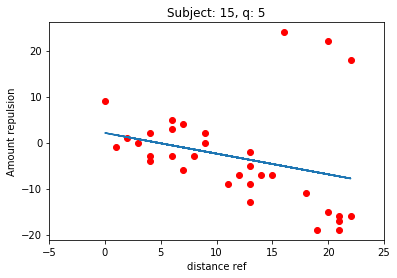

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.5129
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.482
Time:                        12:20:29   Log-Likelihood:                -86.106
No. Observations:                  23   AIC:                             176.2
Df Residuals:                      21   BIC:                             178.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8266      3.768      0.750      0.4

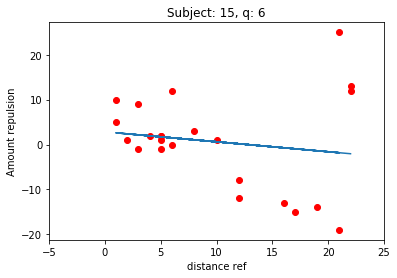

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     5.176
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0321
Time:                        12:20:29   Log-Likelihood:                -81.701
No. Observations:                  26   AIC:                             167.4
Df Residuals:                      24   BIC:                             169.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1186      2.315      0.915      0.3

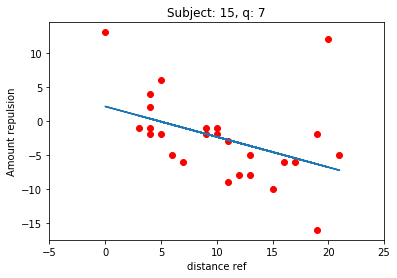

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     6.607
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0152
Time:                        12:20:29   Log-Likelihood:                -110.32
No. Observations:                  33   AIC:                             224.6
Df Residuals:                      31   BIC:                             227.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0839      2.133      1.446      0.1

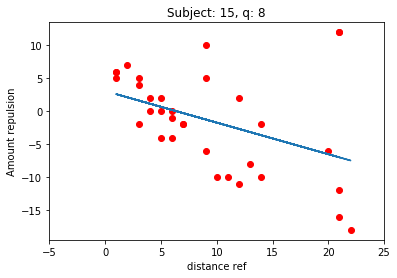

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.170
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.288
Time:                        12:20:30   Log-Likelihood:                -105.05
No. Observations:                  31   AIC:                             214.1
Df Residuals:                      29   BIC:                             217.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.9950      2.447      4.084      0.0

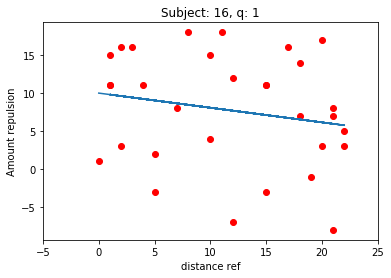

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.042
Method:                 Least Squares   F-statistic:                   0.06291
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.804
Time:                        12:20:30   Log-Likelihood:                -81.930
No. Observations:                  24   AIC:                             167.9
Df Residuals:                      22   BIC:                             170.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9135      3.685      0.248      0.8

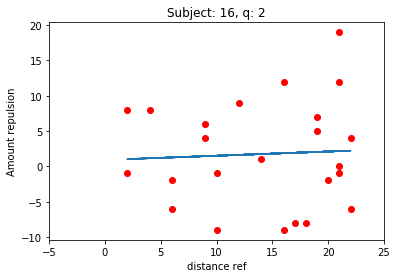

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.8033
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.379
Time:                        12:20:30   Log-Likelihood:                -88.543
No. Observations:                  27   AIC:                             181.1
Df Residuals:                      25   BIC:                             183.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0498      2.659      0.395      0.6

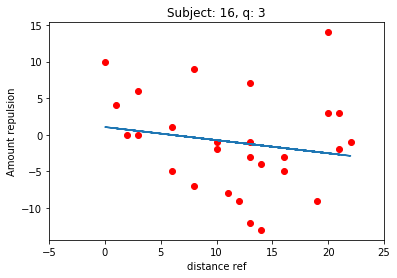

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.042
Method:                 Least Squares   F-statistic:                   0.03739
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.848
Time:                        12:20:30   Log-Likelihood:                -80.385
No. Observations:                  25   AIC:                             164.8
Df Residuals:                      23   BIC:                             167.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.5479      2.195      3.895      0.0

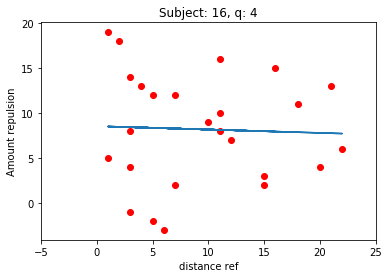

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     2.339
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.137
Time:                        12:20:30   Log-Likelihood:                -96.791
No. Observations:                  30   AIC:                             197.6
Df Residuals:                      28   BIC:                             200.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6257      2.346      1.545      0.1

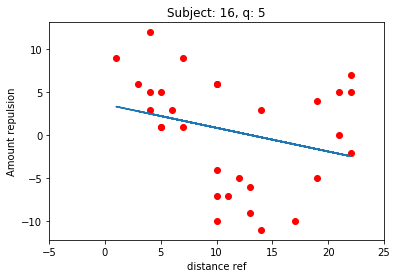

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                    0.2197
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.644
Time:                        12:20:30   Log-Likelihood:                -89.072
No. Observations:                  26   AIC:                             182.1
Df Residuals:                      24   BIC:                             184.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7197      3.084      1.206      0.2

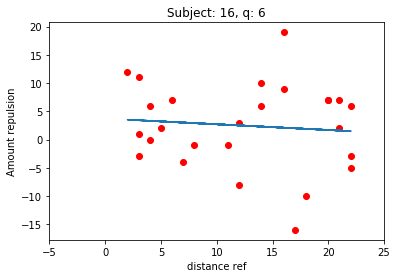

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     2.026
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.170
Time:                        12:20:31   Log-Likelihood:                -68.983
No. Observations:                  22   AIC:                             142.0
Df Residuals:                      20   BIC:                             144.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.5190      2.243      2.461      0.0

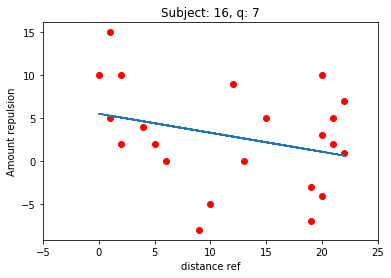

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     9.666
Date:                Tue, 23 Oct 2018   Prob (F-statistic):            0.00378
Time:                        12:20:31   Log-Likelihood:                -117.96
No. Observations:                  36   AIC:                             239.9
Df Residuals:                      34   BIC:                             243.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0746      1.938      3.650      0.0

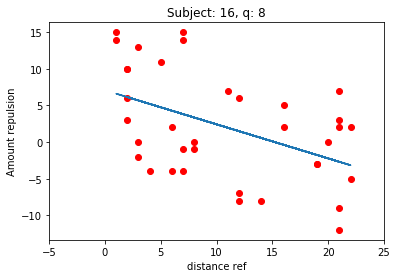

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     7.812
Date:                Tue, 23 Oct 2018   Prob (F-statistic):            0.00882
Time:                        12:20:31   Log-Likelihood:                -104.71
No. Observations:                  33   AIC:                             213.4
Df Residuals:                      31   BIC:                             216.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4585      1.840      2.423      0.0

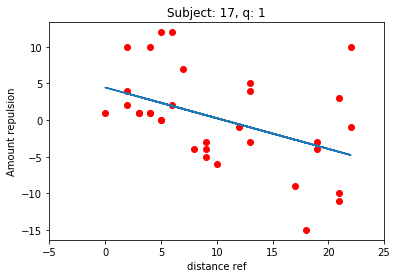

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     14.76
Date:                Tue, 23 Oct 2018   Prob (F-statistic):            0.00144
Time:                        12:20:31   Log-Likelihood:                -54.756
No. Observations:                  18   AIC:                             113.5
Df Residuals:                      16   BIC:                             115.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.2497      2.670      4.589      0.0

C:\Users\David\Anaconda2\envs\python3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


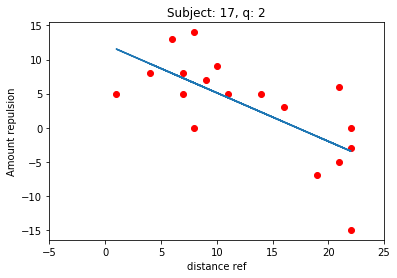

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     8.931
Date:                Tue, 23 Oct 2018   Prob (F-statistic):            0.00700
Time:                        12:20:31   Log-Likelihood:                -76.626
No. Observations:                  23   AIC:                             157.3
Df Residuals:                      21   BIC:                             159.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.7938      2.797      3.859      0.0

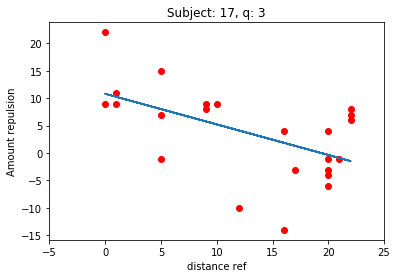

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.037
Method:                 Least Squares   F-statistic:                   0.01013
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.921
Time:                        12:20:31   Log-Likelihood:                -101.58
No. Observations:                  29   AIC:                             207.2
Df Residuals:                      27   BIC:                             209.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4017      3.342     -0.419      0.6

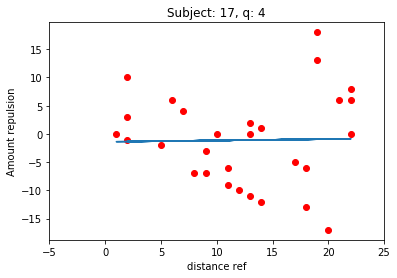

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.323
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.258
Time:                        12:20:31   Log-Likelihood:                -125.13
No. Observations:                  37   AIC:                             254.3
Df Residuals:                      35   BIC:                             257.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6139      2.510      1.440      0.1

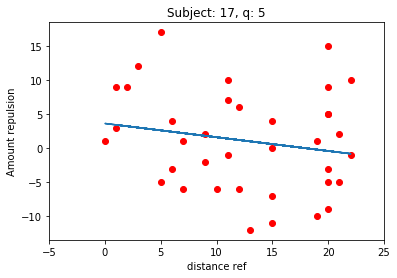

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     1.693
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.208
Time:                        12:20:32   Log-Likelihood:                -78.657
No. Observations:                  22   AIC:                             161.3
Df Residuals:                      20   BIC:                             163.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3624      3.339      1.905      0.0

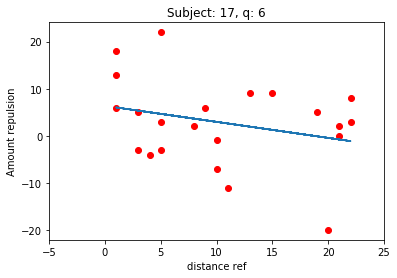

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.269
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.142
Time:                        12:20:32   Log-Likelihood:                -106.53
No. Observations:                  32   AIC:                             217.1
Df Residuals:                      30   BIC:                             220.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2563      2.913      1.805      0.0

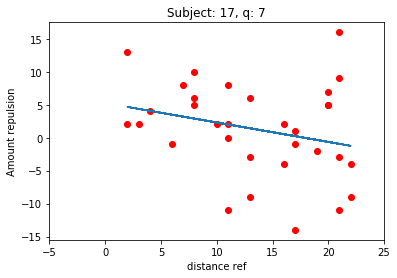

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     6.556
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0175
Time:                        12:20:32   Log-Likelihood:                -88.199
No. Observations:                  25   AIC:                             180.4
Df Residuals:                      23   BIC:                             182.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.6716      4.264      2.034      0.0

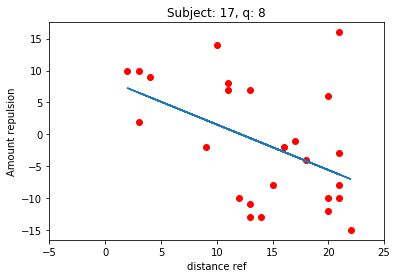

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     4.090
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0508
Time:                        12:20:32   Log-Likelihood:                -125.46
No. Observations:                  37   AIC:                             254.9
Df Residuals:                      35   BIC:                             258.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3423      2.272      2.351      0.0

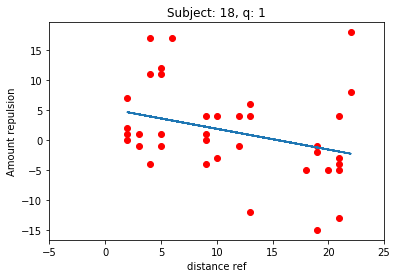

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.8457
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.367
Time:                        12:20:32   Log-Likelihood:                -84.195
No. Observations:                  26   AIC:                             172.4
Df Residuals:                      24   BIC:                             174.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6011      2.464      1.462      0.1

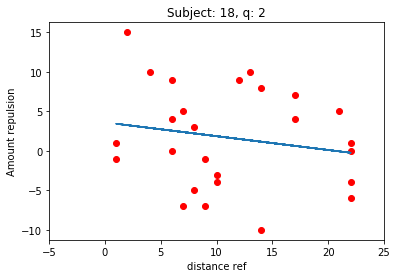

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.149
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.295
Time:                        12:20:32   Log-Likelihood:                -88.861
No. Observations:                  26   AIC:                             181.7
Df Residuals:                      24   BIC:                             184.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6730      2.853      0.586      0.5

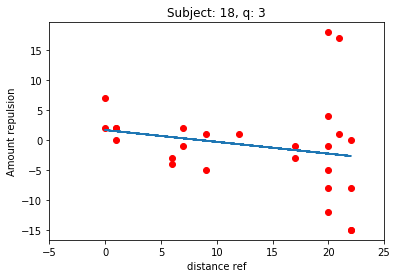

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     7.813
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0112
Time:                        12:20:33   Log-Likelihood:                -71.808
No. Observations:                  22   AIC:                             147.6
Df Residuals:                      20   BIC:                             149.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0429      2.708      2.971      0.0

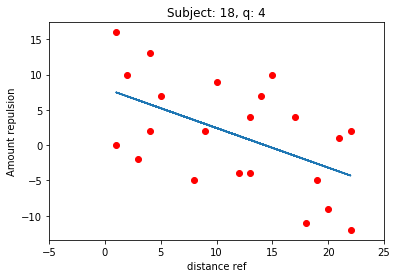

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     4.553
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0409
Time:                        12:20:33   Log-Likelihood:                -111.35
No. Observations:                  33   AIC:                             226.7
Df Residuals:                      31   BIC:                             229.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0535      2.332      2.167      0.0

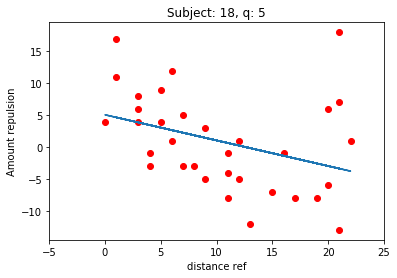

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.250
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.277
Time:                        12:20:33   Log-Likelihood:                -69.828
No. Observations:                  22   AIC:                             143.7
Df Residuals:                      20   BIC:                             145.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8383      2.326      1.220      0.2

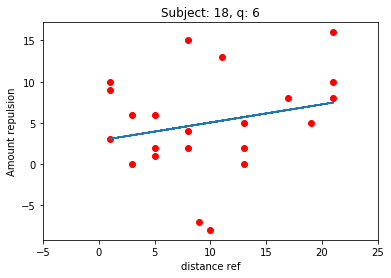

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     22.73
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           3.91e-05
Time:                        12:20:33   Log-Likelihood:                -113.93
No. Observations:                  34   AIC:                             231.9
Df Residuals:                      32   BIC:                             234.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.9033      2.522      4.720      0.0

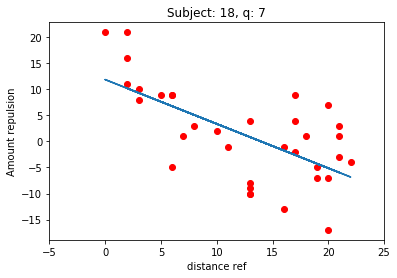

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.029
Method:                 Least Squares   F-statistic:                    0.4728
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.500
Time:                        12:20:33   Log-Likelihood:                -67.289
No. Observations:                  20   AIC:                             138.6
Df Residuals:                      18   BIC:                             140.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.9054      3.162      1.235      0.2

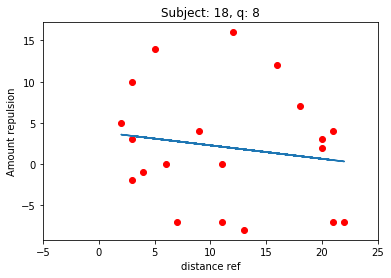

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     25.21
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           1.87e-05
Time:                        12:20:33   Log-Likelihood:                -106.37
No. Observations:                  34   AIC:                             216.7
Df Residuals:                      32   BIC:                             219.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.6115      1.706      7.392      0.0

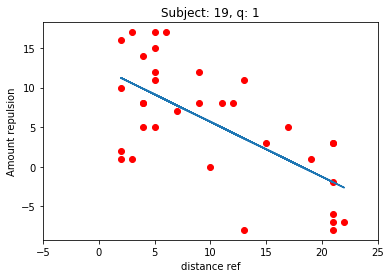

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.7970
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.383
Time:                        12:20:33   Log-Likelihood:                -73.210
No. Observations:                  22   AIC:                             150.4
Df Residuals:                      20   BIC:                             152.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6041      2.972      0.203      0.8

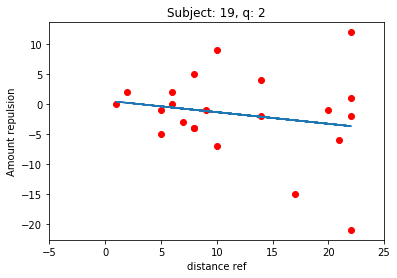

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     4.110
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0539
Time:                        12:20:34   Log-Likelihood:                -92.544
No. Observations:                  26   AIC:                             189.1
Df Residuals:                      24   BIC:                             191.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8661      3.102      1.891      0.0

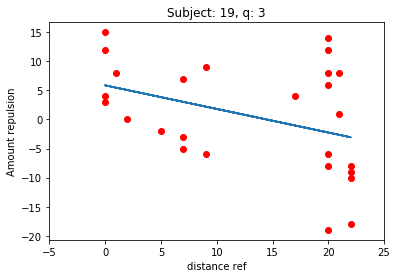

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.040
Method:                 Least Squares   F-statistic:                  0.002021
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.964
Time:                        12:20:34   Log-Likelihood:                -88.681
No. Observations:                  27   AIC:                             181.4
Df Residuals:                      25   BIC:                             184.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3507      2.453      1.366      0.1

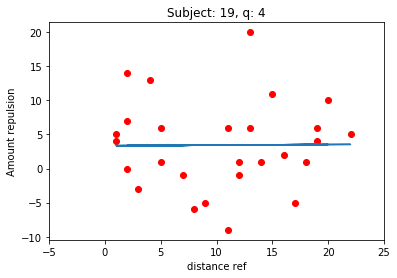

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     4.113
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0525
Time:                        12:20:34   Log-Likelihood:                -104.45
No. Observations:                  29   AIC:                             212.9
Df Residuals:                      27   BIC:                             215.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0579      3.694      1.369      0.1

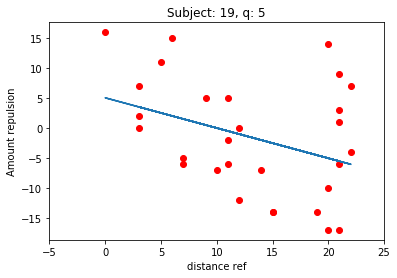

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     9.327
Date:                Tue, 23 Oct 2018   Prob (F-statistic):            0.00546
Time:                        12:20:34   Log-Likelihood:                -84.387
No. Observations:                  26   AIC:                             172.8
Df Residuals:                      24   BIC:                             175.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.9172      2.411      2.039      0.0

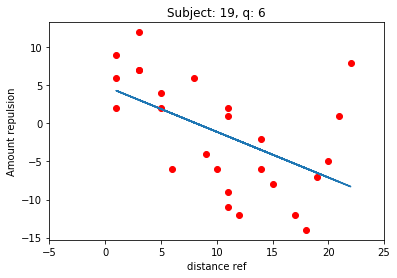

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     8.210
Date:                Tue, 23 Oct 2018   Prob (F-statistic):            0.00832
Time:                        12:20:34   Log-Likelihood:                -86.128
No. Observations:                  27   AIC:                             176.3
Df Residuals:                      25   BIC:                             178.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.3803      2.796      4.070      0.0

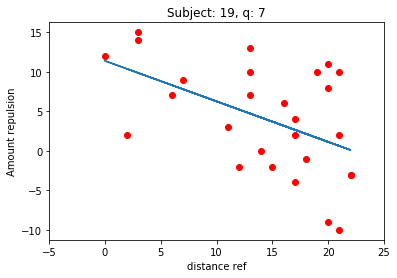

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     15.31
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           0.000557
Time:                        12:20:34   Log-Likelihood:                -93.708
No. Observations:                  29   AIC:                             191.4
Df Residuals:                      27   BIC:                             194.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3119      2.515      2.112      0.0

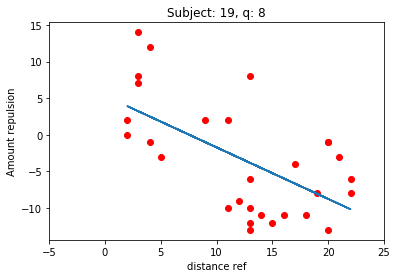

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     5.827
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0241
Time:                        12:20:35   Log-Likelihood:                -85.804
No. Observations:                  25   AIC:                             175.6
Df Residuals:                      23   BIC:                             178.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.3256      2.784      3.349      0.0

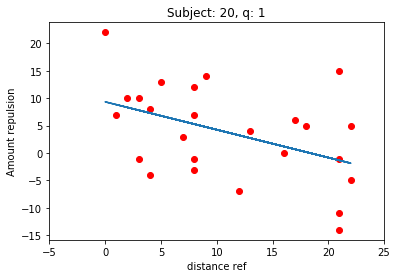

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     4.712
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0491
Time:                        12:20:35   Log-Likelihood:                -50.711
No. Observations:                  15   AIC:                             105.4
Df Residuals:                      13   BIC:                             106.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.1817      4.065      1.521      0.1

C:\Users\David\Anaconda2\envs\python3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


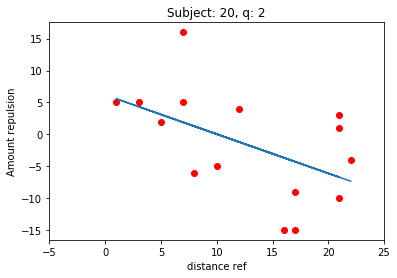

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     2.641
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.121
Time:                        12:20:35   Log-Likelihood:                -73.884
No. Observations:                  21   AIC:                             151.8
Df Residuals:                      19   BIC:                             153.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.4975      3.892      1.669      0.1

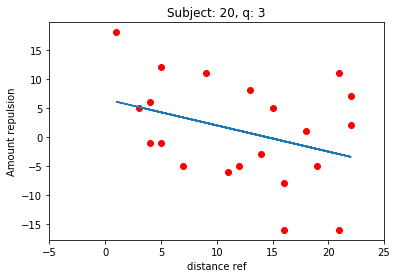

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.7168
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.404
Time:                        12:20:35   Log-Likelihood:                -101.74
No. Observations:                  30   AIC:                             207.5
Df Residuals:                      28   BIC:                             210.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2403      2.497      2.099      0.0

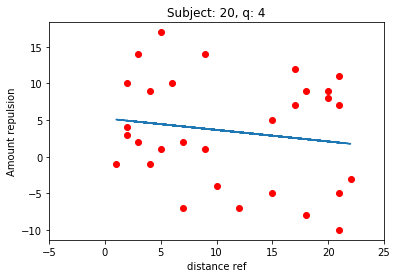

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     19.77
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           0.000223
Time:                        12:20:35   Log-Likelihood:                -76.425
No. Observations:                  23   AIC:                             156.8
Df Residuals:                      21   BIC:                             159.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.2936      2.823      4.001      0.0

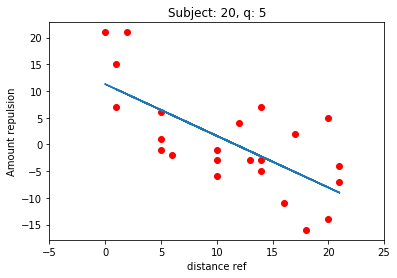

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     20.04
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           9.57e-05
Time:                        12:20:35   Log-Likelihood:                -98.407
No. Observations:                  33   AIC:                             200.8
Df Residuals:                      31   BIC:                             203.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8502      1.707      2.256      0.0

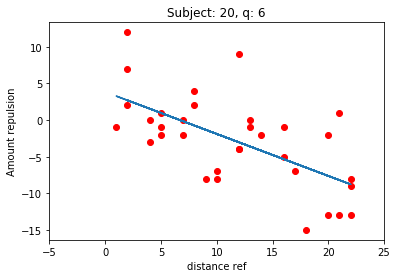

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     6.908
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0132
Time:                        12:20:36   Log-Likelihood:                -115.81
No. Observations:                  33   AIC:                             235.6
Df Residuals:                      31   BIC:                             238.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.7661      2.826      2.040      0.0

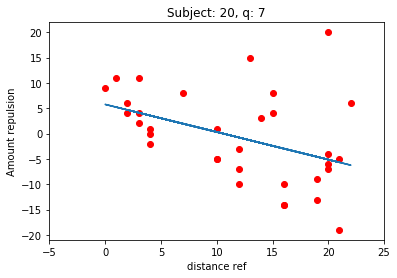

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     5.949
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0237
Time:                        12:20:36   Log-Likelihood:                -72.821
No. Observations:                  23   AIC:                             149.6
Df Residuals:                      21   BIC:                             151.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.8966      2.644      2.609      0.0

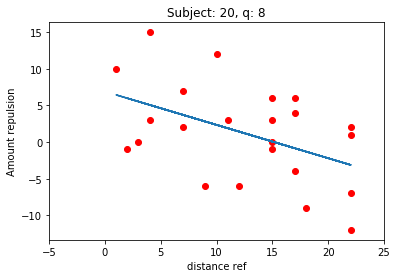

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                    0.2253
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.639
Time:                        12:20:36   Log-Likelihood:                -88.280
No. Observations:                  26   AIC:                             180.6
Df Residuals:                      24   BIC:                             183.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1441      2.895      0.741      0.4

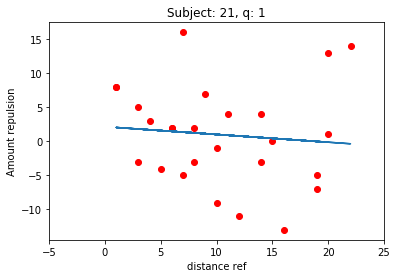

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     44.60
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           8.20e-07
Time:                        12:20:36   Log-Likelihood:                -72.044
No. Observations:                  25   AIC:                             148.1
Df Residuals:                      23   BIC:                             150.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.9528      1.517      5.243      0.0

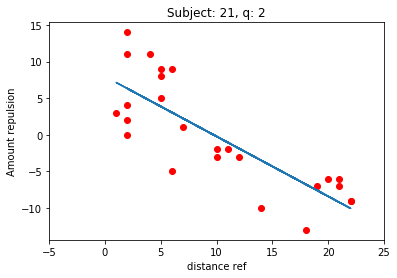

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     12.48
Date:                Tue, 23 Oct 2018   Prob (F-statistic):            0.00118
Time:                        12:20:36   Log-Likelihood:                -122.90
No. Observations:                  37   AIC:                             249.8
Df Residuals:                      35   BIC:                             253.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.5561      1.926      3.404      0.0

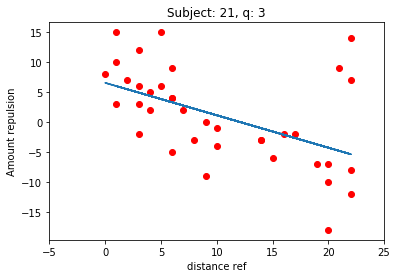

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     36.56
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           2.57e-06
Time:                        12:20:36   Log-Likelihood:                -83.677
No. Observations:                  27   AIC:                             171.4
Df Residuals:                      25   BIC:                             173.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.0370      2.123      4.728      0.0

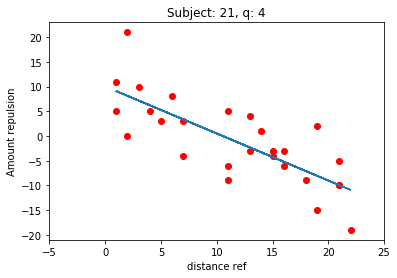

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     6.272
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0186
Time:                        12:20:36   Log-Likelihood:                -97.516
No. Observations:                  29   AIC:                             199.0
Df Residuals:                      27   BIC:                             201.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9498      2.814      2.114      0.0

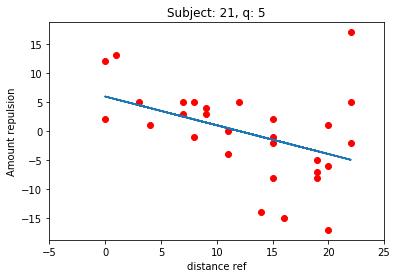

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     2.374
Date:                Tue, 23 Oct 2018   Prob (F-statistic):              0.138
Time:                        12:20:37   Log-Likelihood:                -80.910
No. Observations:                  23   AIC:                             165.8
Df Residuals:                      21   BIC:                             168.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.5753      3.130      1.781      0.0

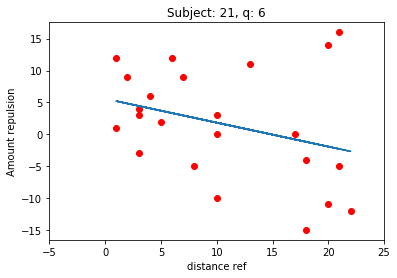

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     6.957
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0147
Time:                        12:20:37   Log-Likelihood:                -87.496
No. Observations:                  25   AIC:                             179.0
Df Residuals:                      23   BIC:                             181.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.9014      3.285      2.405      0.0

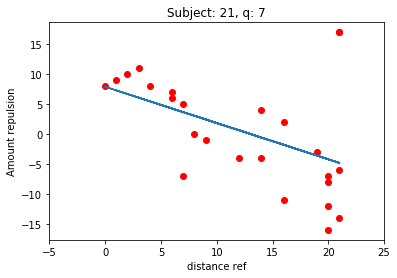

                            OLS Regression Results                            
Dep. Variable:          Repulsion_ref   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     4.846
Date:                Tue, 23 Oct 2018   Prob (F-statistic):             0.0376
Time:                        12:20:37   Log-Likelihood:                -86.002
No. Observations:                  26   AIC:                             176.0
Df Residuals:                      24   BIC:                             178.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.9625      2.553      4.294      0.0

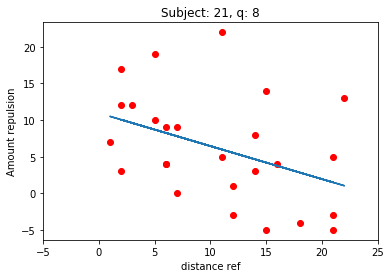

-1.116643695014663
-0.06068894009216637


In [6]:
#Remove the quadrant bias & Remove the mean error (3 Steps)
#Step 1: get the ceoficients of the liniar model in each quadrant and subject 
params={}


## Add octaves
df['octave'] = [get_octave(df.A_T.iloc[i]) for i in range(0, len(df))]
df.head()


for Subject in list_subjects:
    #Data to estimate the LM (ideally it would be type 4 trials)
    #data_SUBJ = df.loc[(df['subject']==Subject) & (df['type']==3)]
    
    #Estimate for each quadrant
    for q, octave in enumerate([1,2,3,4,5,6,7,8]):
        
        #Select data
        data_octave = df.loc[(df['subject']==Subject) & (df['type']!=4) & (df['octave']==octave) ]
        
        #distance to the closest reference (axis and diagonals) from T and response
        dist_ref_T=[]
        dist_ref_R=[]
        for i in range (0, len(data_octave)):
            t, r = data_octave['A_T'].iloc[i], data_octave['A_res'].iloc[i]
            distT, distR = get_dist_ref(t, r)
            dist_ref_T.append(distT)
            dist_ref_R.append(distR)

        dist_ref_T = array(dist_ref_T)
        dist_ref_R = array(dist_ref_R)
        
        #LM: amount repulsion (repulsion = + in this case)
        y=list((dist_ref_R-dist_ref_T).reshape(1, len(data_octave))[0])
        x=list(dist_ref_T.reshape(1, len(data_octave))[0])
        df_LM = pd.DataFrame({"Repulsion_ref":  y, "distancia": x})
        result = smf.ols(formula="Repulsion_ref ~ distancia", data=df_LM).fit()
        print(result.summary())
        
        # Plot for Subject and quadrant
        # use the polyfit function for the plot (line) link https://www.youtube.com/watch?v=yP-7Hhqngbo
        coefs=polyfit(x,y,1) 
        params[str(Subject) + '_' +str(octave)] = coefs
        polinomio=poly1d(coefs)
        #get te line with the expected ys
        ys=polinomio(x)
        plt.title('Subject: ' + str(Subject) +', q: ' + str(octave))
        plt.plot(x,y, 'ro')
        plt.plot(x,ys)
        plt.xlim(-5,25)
        plt.xlabel('distance ref')
        plt.ylabel('Amount repulsion')
        plt.show(block=False)
        plt.show()

        
#Step 2: Remove the effect of the quadrant bias of the target 
Target_bias_corr=[]
for i in range(0, len(df) ):
    coef_use = str(int(df['subject'].iloc[i])) + '_' +str(int(df['cue_resp'].iloc[i]))
    bias_corrected = correct_bias_ref2(df['A_T'].iloc[i], df['A_res'].iloc[i],  params[coef_use])
    Target_bias_corr.append(round(bias_corrected,3))


#Set the new error after substracting the bias
df['A_T_bc'] = Target_bias_corr
df['A_err'] = df[['A_T_bc', 'A_res']].apply(angle_error_col, axis=1)  #df['A_T'] - df['A_R']


print(df.A_err.mean())
# #Step3 :Mean center by quadrant
Mean_error={}

for Subject in list_subjects:
    for q, quadrant in enumerate([1,2,3,4]):        
        data_quadrant = df.loc[(df['subject']==Subject) & (df['type']!=4) & (df['cue_resp']==quadrant) ]
        Mean_error[str(Subject) + '_' +str(quadrant)] = data_quadrant.A_err.mean()
        #print(Mean_error)


        
response_corr=[]
for i in range(0, len(df) ):
    coef_use = str(int(df['subject'].iloc[i])) + '_' +str(int(df['cue_resp'].iloc[i]))
    mean_centered = df['A_res'].iloc[i] + Mean_error[coef_use]
    response_corr.append(round(mean_centered,3))


#Set the new error after mean centering
df['A_R'] = response_corr
df['A_err'] = df[['A_T_bc', 'A_R']].apply(angle_error_col, axis=1) 

print(df.A_err.mean())



In [7]:
# #Remove the quadrant bias & Remove the mean error (3 Steps)

# #Step 1: get the ceoficients of the liniar model in each quadrant and subject 
# params={}

# for Subject in list_subjects:
#     #Data to estimate the LM (ideally it would be type 4 trials)
#     #data_SUBJ = df.loc[(df['subject']==Subject) & (df['type']==3)]
    
#     #Estimate for each quadrant
#     for q, quadrant in enumerate([1,2,3,4]):
        
#         #Select data
#         data_quadrant = df.loc[(df['subject']==Subject) & (df['type']!=4) & (df['cue_resp']==quadrant) ]
        
#         #distance to the closest reference (axis and diagonals) from T and response
#         dist_ref_T=[]
#         dist_ref_R=[]
#         for i in range (0, len(data_quadrant)):
#             t, r = data_quadrant['A_T'].iloc[i], data_quadrant['A_res'].iloc[i]
#             distT, distR = get_dist_ref(t, r)
#             dist_ref_T.append(distT)
#             dist_ref_R.append(distR)

#         dist_ref_T = array(dist_ref_T)
#         dist_ref_R = array(dist_ref_R)
        
#         #LM: amount repulsion (repulsion = + in this case)
#         y=list((dist_ref_R-dist_ref_T).reshape(1, len(data_quadrant))[0])
#         x=list(dist_ref_T.reshape(1, len(data_quadrant))[0])
#         df_LM = pd.DataFrame({"Repulsion_ref":  y, "distancia": x})
#         result = smf.ols(formula="Repulsion_ref ~ distancia", data=df_LM).fit()
#         print(result.summary())
        
#         # Plot for Subject and quadrant
#         # use the polyfit function for the plot (line) link https://www.youtube.com/watch?v=yP-7Hhqngbo
#         coefs=polyfit(x,y,1) 
#         params[str(Subject) + '_' +str(quadrant)] = coefs
#         polinomio=poly1d(coefs)
#         #get te line with the expected ys
#         ys=polinomio(x)
#         plt.title('Subject: ' + str(Subject) +', q: ' + str(quadrant))
#         plt.plot(x,y, 'ro')
#         plt.plot(x,ys)
#         plt.xlim(-5,25)
#         plt.xlabel('distance ref')
#         plt.ylabel('Amount repulsion')
#         plt.show(block=False)
#         plt.show()

        
# #Step 2: Remove the effect of the quadrant bias of the target 
# response_corr=[]
# for i in range(0, len(df) ):
#     coef_use = str(int(df['subject'].iloc[i])) + '_' +str(int(df['cue_resp'].iloc[i]))
#     bias_corrected = correct_bias_axis(df['A_T'].iloc[i], df['A_res'].iloc[i],  params[coef_use])
#     response_corr.append(round(bias_corrected,3))


# #Set the new error after substracting the bias
# df['A_R'] = response_corr
# df['A_err'] = df[['A_T', 'A_R']].apply(angle_error_col, axis=1)  #df['A_T'] - df['A_R']

    


# #Step3 :Mean center by quadrant
# Mean_error={}

# for Subject in list_subjects:
#     for q, quadrant in enumerate([1,2,3,4]):        
#         data_quadrant = df.loc[(df['subject']==Subject) & (df['type']!=4) & (df['cue_resp']==quadrant) ]
#         Mean_error[str(Subject) + '_' +str(quadrant)] = data_quadrant.A_err.mean()


# response_corr=[]
# for i in range(0, len(df) ):
#     coef_use = str(int(df['subject'].iloc[i])) + '_' +str(int(df['cue_resp'].iloc[i]))
#     mean_centered = df['A_R'].iloc[i] + Mean_error[coef_use]
#     response_corr.append(round(mean_centered,3))


# #Set the new error after mean centering
# df['A_R'] = response_corr
# df['A_err'] = df[['A_T', 'A_R']].apply(angle_error_col, axis=1) 



In [8]:
## Add the Interference effect of both
theoretical_interference = Interference_effects(list(df.A_T), list(df.A_res), list(df.A_dist))
corrected_interference = Interference_effects(list(df.A_T_bc), list(df.A_R), list(df.A_dist))
JH_int = Interference_effects(list(df.A_T), list(df.A_R_jh), list(df.A_dist))

df['Interference_theoretical'] = theoretical_interference
df['Interference'] = corrected_interference
df['Interference_JH'] = JH_int

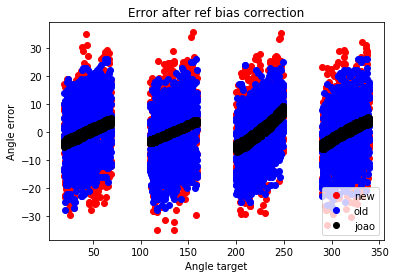

In [9]:
plt.figure()
plt.title('Error after ref bias correction')
plt.plot(df.A_T, df.A_err, 'ro', label='new')
plt.plot(df.A_T, df.A_err_theoretical, 'bo', label='old')
plt.plot(df.A_T, df.A_err_jh, 'ko', label='joao')
plt.xlabel('Angle target')
plt.ylabel('Angle error')

plt.legend(loc=4)
plt.show()

C:\Users\David\Anaconda2\envs\python3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\David\Anaconda2\envs\python3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


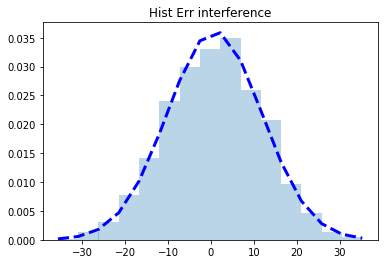

C:\Users\David\Anaconda2\envs\python3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Mean      Sigma
0.83618  11.041062


C:\Users\David\Anaconda2\envs\python3\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


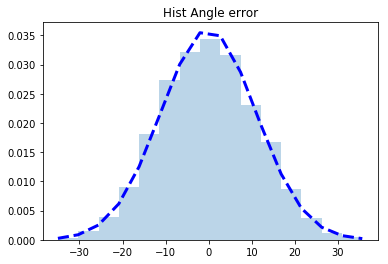

Mean      Sigma
-0.060689  11.072514


In [10]:
#Histogram of the error interference (with a fitted gaussian distribution)
plt.title('Hist Err interference')
#n_bins=15
HIST=plt.hist(df['Interference'], bins=n_bins, alpha=0.3, normed=1)[1]
mu, sigma=norm.fit(df['Interference'])
y_err = plt.mlab.normpdf(HIST, mu, sigma)
plt.plot( HIST, y_err, 'b--', linewidth=3)
plt.show()
dn = pd.DataFrame({"Mean": [mu], "Sigma":[sigma]})
print(dn.to_string(index=False))



plt.title('Hist Angle error')
#n_bins=15
HIST=plt.hist(df['A_err'], bins=n_bins, alpha=0.3, normed=1)[1]
mu, sigma=norm.fit(df['A_err'])
y_err = plt.mlab.normpdf(HIST, mu, sigma)
plt.plot( HIST, y_err, 'b--', linewidth=3)
plt.show()
dn = pd.DataFrame({"Mean": [mu], "Sigma":[sigma]})
print(dn.to_string(index=False))

In [11]:
#data without the controls
# controls = df.loc[df['type']==4]
# data = df.loc[df['type']!=4]

In [12]:
os.chdir(save_path)
df.to_csv('behaviour_psychophysics_corrected')

In [13]:
#Save in a file named data_L3_distractors_fMRI (pickle)
# os.chdir('/home/david/Dropbox/KAROLINSKA/task/POSITIONS/L3_d0,2&7_rad8_resp_same')
# df.to_pickle('data_psychophysics_corrected')
# df.to_csv(r'data_psychophysics_corrected.txt')
# pickle.dump( df, open( "data_L3_distractors_corrected2.p", "wb" ) )

